Hello. This will be a demonstration on creating a pipeline to train a ML model to segment images, as well as a demo of the model in action

This repo provides a dockerfile for setting up a container to run this code in. Once that docker container is running, we will need some more installations before we can start building or training pipeline.

In [1]:
#should really be mostly "requirements already satisfied:" but just in case

# #some installations that our framework depends on 
# !pip install keras
# !pip install tifffile

# #for bayes opt
# !pip install torchvision
# !pip install torch
# !pip install botorch

# #for mask generation
# !pip install rasterio
# !pip install geopandas
# !pip install gdal
# !pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.3/530.3 KB 10.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 17.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 KB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 KB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 KB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 17.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Here we have torch to accomodate the framework we will be using. We will be training a Unet neural network for feature extraction and to generate mask images.

So lets go ahead and import Unet. For this we will be cloning [this repo](https://github.com/reachsumit/deep-unet-for-satellite-image-segmentation/)


In [5]:
!ls ~/deep-unet-for-satellite-image-segmentation

README.md	log_unet.csv  run.sbatch	unet_model.py
data		map.tif       tensorboard_unet	unet_model_deeper.py
gen_patches.py	predict.py    train_unet.py


We have already cloned the repo into our lib folder. If you need to do this you can use the git command with the link provided above

Ok now we have that repo locally. Before we start actually building the pipeline, lets see what our data looks like. Below I will print out a couple images to see what we are working with

In [6]:
import numpy as np
import matplotlib.pyplot as plt # display image
from rasterio.plot import reshape_as_image
from osgeo import gdal
import os
import random

In [7]:
filelocs = ['/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img100.tif',
            '/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img107.tif',
            '/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img111.tif',
            '/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img128.tif',
            '/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img158.tif']
# Read File Raster Data as Array using Gdal
rasters = []
for x in filelocs:
    gtif = gdal.Open(x)
    rasters.append(gtif.ReadAsArray())

plt.subplots(1,5,figsize=(25,5))
for i in range(0,len(rasters)):
    plt.subplot(1,5,i+1)
    plt.imshow(reshape_as_image(rasters[i]))

ERROR 4: /data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img100.tif: No such file or directory


AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

Similarly, there is a folder of geojson files that contain regions for the buildings that appear in these pictures. Keep in mind that some images dont have any buildings, and this can be seen in their corresponding geojson files. The files with buildings typically have entries in the features tag whereas those with out buildings predictably don't have any such features. Here are two examples of this

In [58]:
print("File with no buildings\n")
%cat ~/data/train/geojson/buildings/buildings_AOI_3_Paris_img3.geojson | head -5

print("File with buildings\n")
%cat ~/data/train/geojson/buildings/buildings_AOI_3_Paris_img100.geojson | head -5

File with no buildings

{
"type": "FeatureCollection",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
                                                                                
"features": [

]
}
File with buildings

{
"type": "FeatureCollection",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
                                                                                
"features": [
{ "type": "Feature", "properties": { "OBJECTID_1": 0, "Name_1": "None", "AREA_1": 0.000000, "Shape_Leng": 0.000000, "Shape_Le_1": 0.001890, "Shape_Area": 0.000000, "partialBuilding": 1.000000, "partialDec": 0.078880 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 2.210981399959864, 49.023343219010123, 0.0 ], [ 2.210886256000038, 49.023391452000055, 0.0 ], [ 2.210981399959864, 49.023472155649955, 0.0 ], [ 2.210981399959864, 49.023343219010123, 0.0 ] ] ] } },
{ "type": "Feature", "properties": { "OBJECTID_1": 0, "

You can see that one json is small and has no features whereas the other has about 30 features

Alright now here is maybe the hardest part of the pipeline creation, we have to format our data a little. We need to convert the geojsons that we have to json. Once that is done, the hard part is over. All we need to do is feed this data to the train script we have obtained from Unet. After that we are ready to test the model on our other set of data. 

Using [this](https://lpsmlgeo.github.io/2019-09-22-binary_mask/#4-generate-the-binary-mask) link, we have modified the code that is provided there to generate masks for us, and the py file for this is provided in this repo as generate_masks_from_geojson.py. 

In [38]:
#Use this as needed in case you need to reset the masks folder
!rm ~/data/train/Masks/*

rm: cannot remove '/data/train/Masks/*': No such file or directory


In [41]:

paths = ["/home/jovyan/data/train/geojson/buildings" , #geojsons
         "/home/jovyan/data/train/RGB-PanSharpen", #tifs
         "/home/jovyan/data/train/Masks"] #output dir
!python ~/src/generate_masks_from_geojson.py {paths[0]} {paths[1]} {paths[2]}


tifDirList length: 1148

Creating output directory if it doesnt exist

Already Exists: /data/train/Masks

Commencing mask gen

Mask gen complete. 1148 masks made. Please check your directory


Lets see if it worked

In [112]:
import os
print(os.listdir("/home/jovyan/data/train/Masks"))

['buildings_AOI_3_Paris_img1102.tif', 'buildings_AOI_3_Paris_img1898.tif', 'buildings_AOI_3_Paris_img613.tif', 'buildings_AOI_3_Paris_img272.tif', 'buildings_AOI_3_Paris_img976.tif', 'buildings_AOI_3_Paris_img165.tif', 'buildings_AOI_3_Paris_img1849.tif', 'buildings_AOI_3_Paris_img852.tif', 'buildings_AOI_3_Paris_img387.tif', 'buildings_AOI_3_Paris_img56.tif', 'buildings_AOI_3_Paris_img1608.tif', 'buildings_AOI_3_Paris_img356.tif', 'buildings_AOI_3_Paris_img1331.tif', 'buildings_AOI_3_Paris_img1496.tif', 'buildings_AOI_3_Paris_img1750.tif', 'buildings_AOI_3_Paris_img1026.tif', 'buildings_AOI_3_Paris_img578.tif', 'buildings_AOI_3_Paris_img119.tif', 'buildings_AOI_3_Paris_img380.tif', 'buildings_AOI_3_Paris_img427.tif', 'buildings_AOI_3_Paris_img855.tif', 'buildings_AOI_3_Paris_img1179.tif', 'buildings_AOI_3_Paris_img730.tif', 'buildings_AOI_3_Paris_img351.tif', 'buildings_AOI_3_Paris_img1491.tif', 'buildings_AOI_3_Paris_img1336.tif', 'buildings_AOI_3_Paris_img209.tif', 'buildings_AOI_3_

The directory shows that images were indeed made at the location we specified. Lets now see the images and their corresponding masks.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


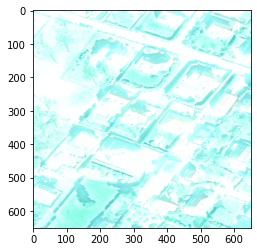

(650, 650)


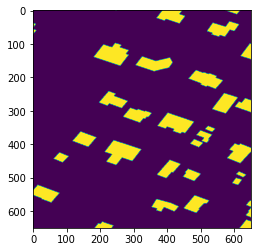

In [59]:

gtif = gdal.Open('/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img746.tif')
image = gtif.ReadAsArray()

gtif = gdal.Open('/home/jovyan/data/train/Masks/buildings_AOI_3_Paris_img746.tif')
mask = gtif.ReadAsArray()
print(mask.shape)

plt.subplots(1,2,figsize=(15,5))
plt.imshow(reshape_as_image(image))
plt.subplot(1,2,1)
plt.imshow(reshape_as_image([mask]))
plt.subplot(1,2,2)
plt.show()

gtif = None

Here is one example of a mask made for the image above it. It shows the network where the pixels that belong to buildings are. Using this data, we will now train Unet.

We need to make some modifications to the repo that we downloaded earlier. Namely some of the hyperparameters like Band Size and Number of Classes, as well as all the path strings so they match the current set up. After this is all done. Simply invoke the script and it should start training a model. 

Since we have a large number of images (1000+), I have set it so that it will only look at the first 500 images. For each batch it takes 50 from the 500.the model augments the data by taking 160x160 size patches from the batch 1000 times. So for each batch it ends up looking at 1000 160x160 crops from the 50 images in a batch. It will do this 10000 times (10000 Epochs) so that it can  get a good understanding of the data.

Alright now that we understand some of the specifics of what it is doing, lets run the script.

In [82]:
!python ~/work/unet/train_unet.py

2021-06-23 23:30:39.351346: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Weights Folder Already Exists
getting model
Reading images
1	RGB-PanSharpen_AOI_3_Paris_img1478.tif read
2	RGB-PanSharpen_AOI_3_Paris_img841.tif read
3	RGB-PanSharpen_AOI_3_Paris_img1019.tif read
4	RGB-PanSharpen_AOI_3_Paris_img724.tif read
5	RGB-PanSharpen_AOI_3_Paris_img890.tif read
6	RGB-PanSharpen_AOI_3_Paris_img345.tif read
7	RGB-PanSharpen_AOI_3_Paris_img1256.tif read
8	RGB-PanSharpen_AOI_3_Paris_img1141.tif read
9	RGB-PanSharpen_AOI_3_Paris_img1404.tif read
10	RGB-PanSharpen_AOI_3_Paris_img789.tif read
11	RGB-PanSharpen_AOI_3_Paris_img1065.tif read
12	RGB-PanSharpen_AOI_3_Paris_img1713.tif read
13	RGB-PanSharpen_AOI_3_Paris_img339.tif read
14	RGB-PanSharpen_AOI_3_Paris_img1372.tif read
15	RGB-PanSharpen_AOI_3_Paris_img600.tif read
16	RGB-PanSharpen_AOI_3_Paris_img261.tif read
17	RGB-PanSharpen_AOI_3_Paris_img517.tif read
18	RGB-PanShar

173	RGB-PanSharpen_AOI_3_Paris_img1207.tif read
174	RGB-PanSharpen_AOI_3_Paris_img1666.tif read
175	RGB-PanSharpen_AOI_3_Paris_img948.tif read
176	RGB-PanSharpen_AOI_3_Paris_img1048.tif read
177	RGB-PanSharpen_AOI_3_Paris_img1429.tif read
178	RGB-PanSharpen_AOI_3_Paris_img462.tif read
179	RGB-PanSharpen_AOI_3_Paris_img314.tif read
180	RGB-PanSharpen_AOI_3_Paris_img3.tif read
181	RGB-PanSharpen_AOI_3_Paris_img775.tif read
182	RGB-PanSharpen_AOI_3_Paris_img230.tif read
183	RGB-PanSharpen_AOI_3_Paris_img597.tif read
184	RGB-PanSharpen_AOI_3_Paris_img651.tif read
185	RGB-PanSharpen_AOI_3_Paris_img680.tif read
186	RGB-PanSharpen_AOI_3_Paris_img127.tif read
187	RGB-PanSharpen_AOI_3_Paris_img546.tif read
188	RGB-PanSharpen_AOI_3_Paris_img1793.tif read
189	RGB-PanSharpen_AOI_3_Paris_img1034.tif read
190	RGB-PanSharpen_AOI_3_Paris_img1455.tif read
191	RGB-PanSharpen_AOI_3_Paris_img368.tif read
192	RGB-PanSharpen_AOI_3_Paris_img1484.tif read
193	RGB-PanSharpen_AOI_3_Paris_img1742.tif read
194	RG

347	RGB-PanSharpen_AOI_3_Paris_img673.tif read
348	RGB-PanSharpen_AOI_3_Paris_img212.tif read
349	RGB-PanSharpen_AOI_3_Paris_img564.tif read
350	RGB-PanSharpen_AOI_3_Paris_img832.tif read
351	RGB-PanSharpen_AOI_3_Paris_img440.tif read
352	RGB-PanSharpen_AOI_3_Paris_img1879.tif read
353	RGB-PanSharpen_AOI_3_Paris_img786.tif read
354	RGB-PanSharpen_AOI_3_Paris_img757.tif read
355	RGB-PanSharpen_AOI_3_Paris_img491.tif read
356	RGB-PanSharpen_AOI_3_Paris_img336.tif read
357	RGB-PanSharpen_AOI_3_Paris_img1644.tif read
358	RGB-PanSharpen_AOI_3_Paris_img1225.tif read
359	RGB-PanSharpen_AOI_3_Paris_img518.tif read
360	RGB-PanSharpen_AOI_3_Paris_img1553.tif read
361	RGB-PanSharpen_AOI_3_Paris_img1132.tif read
362	RGB-PanSharpen_AOI_3_Paris_img781.tif read
363	RGB-PanSharpen_AOI_3_Paris_img750.tif read
364	RGB-PanSharpen_AOI_3_Paris_img1643.tif read
365	RGB-PanSharpen_AOI_3_Paris_img608.tif read
366	RGB-PanSharpen_AOI_3_Paris_img269.tif read
367	RGB-PanSharpen_AOI_3_Paris_img1585.tif read
368	RG

2021-06-23 23:31:04.014210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-06-23 23:31:04.014248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-06-23 23:31:04.014255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-06-23 23:31:04.014389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-23 23:31:04.014729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-23 23:31:04.015042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-

16/16 - 3s - loss: 0.1670 - val_loss: 0.2756
Epoch 7/10000
16/16 - 3s - loss: 0.1634 - val_loss: 0.2631
Epoch 8/10000
16/16 - 3s - loss: 0.1607 - val_loss: 0.2841
Epoch 9/10000
16/16 - 3s - loss: 0.1533 - val_loss: 0.3403
Epoch 10/10000
16/16 - 3s - loss: 0.1450 - val_loss: 0.7562
Epoch 11/10000
16/16 - 3s - loss: 0.1449 - val_loss: 0.4363
Epoch 12/10000
16/16 - 3s - loss: 0.1580 - val_loss: 0.2241
Epoch 13/10000
16/16 - 3s - loss: 0.1558 - val_loss: 0.5047
Epoch 14/10000
16/16 - 3s - loss: 0.1514 - val_loss: 0.4335
Epoch 15/10000
16/16 - 3s - loss: 0.1468 - val_loss: 0.2565
Epoch 16/10000
16/16 - 3s - loss: 0.1532 - val_loss: 0.2624
Epoch 17/10000
16/16 - 3s - loss: 0.1461 - val_loss: 0.3395
Epoch 18/10000
16/16 - 3s - loss: 0.1412 - val_loss: 0.4885
Epoch 19/10000
16/16 - 3s - loss: 0.1416 - val_loss: 0.3954
Epoch 20/10000
16/16 - 3s - loss: 0.1403 - val_loss: 0.3603
Epoch 21/10000
16/16 - 3s - loss: 0.1407 - val_loss: 1.5976
Epoch 22/10000
16/16 - 3s - loss: 0.1399 - val_loss: 1.248

16/16 - 3s - loss: 0.0217 - val_loss: 0.4820
Epoch 143/10000
16/16 - 3s - loss: 0.0209 - val_loss: 0.6155
Epoch 144/10000
16/16 - 3s - loss: 0.0211 - val_loss: 0.6108
Epoch 145/10000
16/16 - 3s - loss: 0.0212 - val_loss: 0.4612
Epoch 146/10000
16/16 - 3s - loss: 0.0196 - val_loss: 0.7141
Epoch 147/10000
16/16 - 3s - loss: 0.0184 - val_loss: 0.6500
Epoch 148/10000
16/16 - 3s - loss: 0.0184 - val_loss: 0.5109
Epoch 149/10000
16/16 - 3s - loss: 0.0195 - val_loss: 0.5386
Epoch 150/10000
16/16 - 3s - loss: 0.0192 - val_loss: 0.4135
Epoch 151/10000
16/16 - 3s - loss: 0.0204 - val_loss: 0.4348
Epoch 152/10000
16/16 - 3s - loss: 0.0179 - val_loss: 0.4332
Epoch 153/10000
16/16 - 3s - loss: 0.0172 - val_loss: 0.4763
Epoch 154/10000
16/16 - 3s - loss: 0.0160 - val_loss: 0.5943
Epoch 155/10000
16/16 - 3s - loss: 0.0155 - val_loss: 0.4583
Epoch 156/10000
16/16 - 3s - loss: 0.0145 - val_loss: 0.4968
Epoch 157/10000
16/16 - 3s - loss: 0.0140 - val_loss: 0.5758
Epoch 158/10000
16/16 - 3s - loss: 0.015

16/16 - 3s - loss: 0.0059 - val_loss: 0.8743
Epoch 278/10000
16/16 - 3s - loss: 0.0057 - val_loss: 0.9847
Epoch 279/10000
16/16 - 3s - loss: 0.0056 - val_loss: 0.9760
Epoch 280/10000
16/16 - 3s - loss: 0.0055 - val_loss: 1.0211
Epoch 281/10000
16/16 - 3s - loss: 0.0055 - val_loss: 0.8957
Epoch 282/10000
16/16 - 3s - loss: 0.0057 - val_loss: 1.1389
Epoch 283/10000
16/16 - 3s - loss: 0.0058 - val_loss: 1.1502
Epoch 284/10000
16/16 - 3s - loss: 0.0055 - val_loss: 1.2191
Epoch 285/10000
16/16 - 3s - loss: 0.0054 - val_loss: 1.1415
Epoch 286/10000
16/16 - 3s - loss: 0.0053 - val_loss: 1.2204
Epoch 287/10000
16/16 - 3s - loss: 0.0055 - val_loss: 1.2039
Epoch 288/10000
16/16 - 3s - loss: 0.0055 - val_loss: 1.2860
Epoch 289/10000
16/16 - 3s - loss: 0.0055 - val_loss: 1.0998
Epoch 290/10000
16/16 - 3s - loss: 0.0054 - val_loss: 1.1826
Epoch 291/10000
16/16 - 3s - loss: 0.0055 - val_loss: 1.1279
Epoch 292/10000
16/16 - 3s - loss: 0.0055 - val_loss: 1.2049
Epoch 293/10000
16/16 - 3s - loss: 0.005

16/16 - 3s - loss: 0.0049 - val_loss: 0.6992
Epoch 413/10000
16/16 - 3s - loss: 0.0048 - val_loss: 0.7070
Epoch 414/10000
16/16 - 3s - loss: 0.0047 - val_loss: 0.7115
Epoch 415/10000
16/16 - 3s - loss: 0.0047 - val_loss: 0.7759
Epoch 416/10000
16/16 - 3s - loss: 0.0083 - val_loss: 0.4606
Epoch 417/10000
16/16 - 3s - loss: 0.0325 - val_loss: 1.0240
Epoch 418/10000
16/16 - 3s - loss: 0.0164 - val_loss: 0.8948
Epoch 419/10000
16/16 - 3s - loss: 0.0192 - val_loss: 0.5059
Epoch 420/10000
16/16 - 3s - loss: 0.0158 - val_loss: 0.5337
Epoch 421/10000
16/16 - 3s - loss: 0.0122 - val_loss: 0.8491
Epoch 422/10000
16/16 - 3s - loss: 0.0081 - val_loss: 0.7660
Epoch 423/10000
16/16 - 3s - loss: 0.0070 - val_loss: 1.0943
Epoch 424/10000
16/16 - 3s - loss: 0.0061 - val_loss: 1.1168
Epoch 425/10000
16/16 - 3s - loss: 0.0058 - val_loss: 1.1034
Epoch 426/10000
16/16 - 3s - loss: 0.0057 - val_loss: 1.0866
Epoch 427/10000
16/16 - 3s - loss: 0.0056 - val_loss: 0.9708
Epoch 428/10000
16/16 - 3s - loss: 0.005

16/16 - 3s - loss: 0.0030 - val_loss: 1.1002
Epoch 548/10000
16/16 - 3s - loss: 0.0029 - val_loss: 1.1890
Epoch 549/10000
16/16 - 3s - loss: 0.0029 - val_loss: 1.2073
Epoch 550/10000
16/16 - 3s - loss: 0.0029 - val_loss: 1.1010
Epoch 551/10000
16/16 - 3s - loss: 0.0029 - val_loss: 1.1821
Epoch 552/10000
16/16 - 3s - loss: 0.0030 - val_loss: 1.1999
Epoch 553/10000
16/16 - 3s - loss: 0.0030 - val_loss: 1.2419
Epoch 554/10000
16/16 - 3s - loss: 0.0029 - val_loss: 1.1029
Epoch 555/10000
16/16 - 3s - loss: 0.0029 - val_loss: 1.1001
Epoch 556/10000
16/16 - 3s - loss: 0.0029 - val_loss: 1.0873
Epoch 557/10000
16/16 - 3s - loss: 0.0030 - val_loss: 1.0163
Epoch 558/10000
16/16 - 3s - loss: 0.0029 - val_loss: 1.1250
Epoch 559/10000
16/16 - 3s - loss: 0.0028 - val_loss: 1.1501
Epoch 560/10000
16/16 - 3s - loss: 0.0028 - val_loss: 1.1510
Epoch 561/10000
16/16 - 3s - loss: 0.0028 - val_loss: 1.2277
Epoch 562/10000
16/16 - 3s - loss: 0.0028 - val_loss: 1.1551
Epoch 563/10000
16/16 - 3s - loss: 0.002

16/16 - 3s - loss: 0.0036 - val_loss: 0.8473
Epoch 683/10000
16/16 - 3s - loss: 0.0034 - val_loss: 0.8786
Epoch 684/10000
16/16 - 3s - loss: 0.0034 - val_loss: 0.8156
Epoch 685/10000
16/16 - 3s - loss: 0.0033 - val_loss: 0.9972
Epoch 686/10000
16/16 - 3s - loss: 0.0032 - val_loss: 0.8741
Epoch 687/10000
16/16 - 3s - loss: 0.0032 - val_loss: 0.7616
Epoch 688/10000
16/16 - 3s - loss: 0.0031 - val_loss: 0.8176
Epoch 689/10000
16/16 - 3s - loss: 0.0031 - val_loss: 0.9189
Epoch 690/10000
16/16 - 3s - loss: 0.0030 - val_loss: 0.9245
Epoch 691/10000
16/16 - 3s - loss: 0.0031 - val_loss: 0.8953
Epoch 692/10000
16/16 - 3s - loss: 0.0029 - val_loss: 0.9546
Epoch 693/10000
16/16 - 3s - loss: 0.0030 - val_loss: 0.8679
Epoch 694/10000
16/16 - 3s - loss: 0.0030 - val_loss: 0.8626
Epoch 695/10000
16/16 - 3s - loss: 0.0029 - val_loss: 0.8875
Epoch 696/10000
16/16 - 3s - loss: 0.0029 - val_loss: 0.8861
Epoch 697/10000
16/16 - 3s - loss: 0.0029 - val_loss: 0.9056
Epoch 698/10000
16/16 - 3s - loss: 0.002

16/16 - 4s - loss: 0.0024 - val_loss: 0.8829
Epoch 818/10000
16/16 - 4s - loss: 0.0025 - val_loss: 0.8547
Epoch 819/10000
16/16 - 4s - loss: 0.0024 - val_loss: 0.8625
Epoch 820/10000
16/16 - 4s - loss: 0.0023 - val_loss: 0.9043
Epoch 821/10000
16/16 - 4s - loss: 0.0023 - val_loss: 0.8648
Epoch 822/10000
16/16 - 4s - loss: 0.0023 - val_loss: 0.8668
Epoch 823/10000
16/16 - 4s - loss: 0.0022 - val_loss: 0.9028
Epoch 824/10000
16/16 - 4s - loss: 0.0022 - val_loss: 0.8979
Epoch 825/10000
16/16 - 4s - loss: 0.0023 - val_loss: 0.9373
Epoch 826/10000
16/16 - 4s - loss: 0.0022 - val_loss: 0.9152
Epoch 827/10000
16/16 - 4s - loss: 0.0022 - val_loss: 0.9225
Epoch 828/10000
16/16 - 4s - loss: 0.0022 - val_loss: 0.9925
Epoch 829/10000
16/16 - 4s - loss: 0.0021 - val_loss: 1.0997
Epoch 830/10000
16/16 - 4s - loss: 0.0021 - val_loss: 0.9699
Epoch 831/10000
16/16 - 4s - loss: 0.0021 - val_loss: 0.9609
Epoch 832/10000
16/16 - 4s - loss: 0.0021 - val_loss: 0.9689
Epoch 833/10000
16/16 - 4s - loss: 0.002

16/16 - 3s - loss: 0.0026 - val_loss: 0.9119
Epoch 953/10000
16/16 - 3s - loss: 0.0023 - val_loss: 0.9129
Epoch 954/10000
16/16 - 3s - loss: 0.0021 - val_loss: 1.1839
Epoch 955/10000
16/16 - 3s - loss: 0.0020 - val_loss: 1.0448
Epoch 956/10000
16/16 - 3s - loss: 0.0019 - val_loss: 0.9368
Epoch 957/10000
16/16 - 3s - loss: 0.0019 - val_loss: 1.0247
Epoch 958/10000
16/16 - 3s - loss: 0.0018 - val_loss: 1.0310
Epoch 959/10000
16/16 - 3s - loss: 0.0017 - val_loss: 1.1070
Epoch 960/10000
16/16 - 3s - loss: 0.0017 - val_loss: 1.0968
Epoch 961/10000
16/16 - 3s - loss: 0.0018 - val_loss: 1.0401
Epoch 962/10000
16/16 - 3s - loss: 0.0017 - val_loss: 1.1308
Epoch 963/10000
16/16 - 3s - loss: 0.0017 - val_loss: 1.0097
Epoch 964/10000
16/16 - 3s - loss: 0.0017 - val_loss: 1.1957
Epoch 965/10000
16/16 - 3s - loss: 0.0016 - val_loss: 1.1147
Epoch 966/10000
16/16 - 4s - loss: 0.0017 - val_loss: 1.1152
Epoch 967/10000
16/16 - 4s - loss: 0.0016 - val_loss: 1.2292
Epoch 968/10000
16/16 - 4s - loss: 0.001

16/16 - 3s - loss: 0.0014 - val_loss: 1.5803
Epoch 1086/10000
16/16 - 3s - loss: 0.0013 - val_loss: 1.4347
Epoch 1087/10000
16/16 - 3s - loss: 0.0013 - val_loss: 1.2358
Epoch 1088/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.5688
Epoch 1089/10000
16/16 - 3s - loss: 0.0013 - val_loss: 1.5674
Epoch 1090/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.4759
Epoch 1091/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.5765
Epoch 1092/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.6276
Epoch 1093/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.5039
Epoch 1094/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.4801
Epoch 1095/10000
16/16 - 3s - loss: 0.0011 - val_loss: 1.3405
Epoch 1096/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.6664
Epoch 1097/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.6526
Epoch 1098/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.2397
Epoch 1099/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.4990
Epoch 1100/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.4162
Epoch 1101/10000
16/16 - 

16/16 - 3s - loss: 0.0012 - val_loss: 1.0226
Epoch 1219/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.0376
Epoch 1220/10000
16/16 - 3s - loss: 0.0011 - val_loss: 1.1122
Epoch 1221/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.1064
Epoch 1222/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.1388
Epoch 1223/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.0586
Epoch 1224/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.0478
Epoch 1225/10000
16/16 - 3s - loss: 0.0011 - val_loss: 1.0222
Epoch 1226/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.0716
Epoch 1227/10000
16/16 - 3s - loss: 0.0011 - val_loss: 1.0842
Epoch 1228/10000
16/16 - 3s - loss: 0.0011 - val_loss: 1.1135
Epoch 1229/10000
16/16 - 3s - loss: 0.0011 - val_loss: 1.1011
Epoch 1230/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.0861
Epoch 1231/10000
16/16 - 3s - loss: 0.0011 - val_loss: 1.1378
Epoch 1232/10000
16/16 - 3s - loss: 0.0011 - val_loss: 1.1484
Epoch 1233/10000
16/16 - 3s - loss: 0.0012 - val_loss: 1.0912
Epoch 1234/10000
16/16 - 

16/16 - 3s - loss: 9.3944e-04 - val_loss: 1.1808
Epoch 1350/10000
16/16 - 3s - loss: 9.2099e-04 - val_loss: 1.2310
Epoch 1351/10000
16/16 - 3s - loss: 9.1590e-04 - val_loss: 1.1686
Epoch 1352/10000
16/16 - 3s - loss: 9.1222e-04 - val_loss: 1.2082
Epoch 1353/10000
16/16 - 3s - loss: 9.2087e-04 - val_loss: 1.2328
Epoch 1354/10000
16/16 - 3s - loss: 9.0697e-04 - val_loss: 1.1486
Epoch 1355/10000
16/16 - 3s - loss: 8.8555e-04 - val_loss: 1.1986
Epoch 1356/10000
16/16 - 3s - loss: 8.9372e-04 - val_loss: 1.2675
Epoch 1357/10000
16/16 - 3s - loss: 9.0040e-04 - val_loss: 1.2042
Epoch 1358/10000
16/16 - 3s - loss: 9.3168e-04 - val_loss: 1.2077
Epoch 1359/10000
16/16 - 3s - loss: 9.5310e-04 - val_loss: 1.2019
Epoch 1360/10000
16/16 - 3s - loss: 9.3910e-04 - val_loss: 1.1632
Epoch 1361/10000
16/16 - 3s - loss: 9.2772e-04 - val_loss: 1.2182
Epoch 1362/10000
16/16 - 3s - loss: 9.4437e-04 - val_loss: 1.2022
Epoch 1363/10000
16/16 - 3s - loss: 9.5838e-04 - val_loss: 1.2310
Epoch 1364/10000
16/16 - 3s

16/16 - 3s - loss: 8.0274e-04 - val_loss: 1.4297
Epoch 1475/10000
16/16 - 3s - loss: 7.7420e-04 - val_loss: 1.3716
Epoch 1476/10000
16/16 - 3s - loss: 7.9868e-04 - val_loss: 1.5865
Epoch 1477/10000
16/16 - 3s - loss: 7.3766e-04 - val_loss: 1.4744
Epoch 1478/10000
16/16 - 3s - loss: 7.4975e-04 - val_loss: 1.4953
Epoch 1479/10000
16/16 - 3s - loss: 7.5759e-04 - val_loss: 1.5535
Epoch 1480/10000
16/16 - 3s - loss: 8.6751e-04 - val_loss: 1.2320
Epoch 1481/10000
16/16 - 3s - loss: 8.4181e-04 - val_loss: 1.2059
Epoch 1482/10000
16/16 - 3s - loss: 8.1200e-04 - val_loss: 1.2363
Epoch 1483/10000
16/16 - 3s - loss: 8.1948e-04 - val_loss: 1.3385
Epoch 1484/10000
16/16 - 3s - loss: 7.9303e-04 - val_loss: 1.3595
Epoch 1485/10000
16/16 - 3s - loss: 7.8801e-04 - val_loss: 1.4872
Epoch 1486/10000
16/16 - 3s - loss: 7.9475e-04 - val_loss: 1.6752
Epoch 1487/10000
16/16 - 3s - loss: 8.0330e-04 - val_loss: 1.5207
Epoch 1488/10000
16/16 - 3s - loss: 8.2229e-04 - val_loss: 1.8425
Epoch 1489/10000
16/16 - 3s

16/16 - 4s - loss: 8.3033e-04 - val_loss: 1.2508
Epoch 1603/10000
16/16 - 4s - loss: 8.5906e-04 - val_loss: 1.2772
Epoch 1604/10000
16/16 - 4s - loss: 8.5277e-04 - val_loss: 1.2185
Epoch 1605/10000
16/16 - 4s - loss: 8.3645e-04 - val_loss: 1.2437
Epoch 1606/10000
16/16 - 4s - loss: 8.6801e-04 - val_loss: 1.2670
Epoch 1607/10000
16/16 - 4s - loss: 9.0483e-04 - val_loss: 1.2014
Epoch 1608/10000
16/16 - 3s - loss: 8.0513e-04 - val_loss: 1.2034
Epoch 1609/10000
16/16 - 3s - loss: 7.9674e-04 - val_loss: 1.2330
Epoch 1610/10000
16/16 - 3s - loss: 8.0627e-04 - val_loss: 1.2707
Epoch 1611/10000
16/16 - 3s - loss: 7.9478e-04 - val_loss: 1.2975
Epoch 1612/10000
16/16 - 3s - loss: 7.5171e-04 - val_loss: 1.2788
Epoch 1613/10000
16/16 - 3s - loss: 7.6253e-04 - val_loss: 1.2676
Epoch 1614/10000
16/16 - 3s - loss: 7.7499e-04 - val_loss: 1.2953
Epoch 1615/10000
16/16 - 3s - loss: 7.6093e-04 - val_loss: 1.3076
Epoch 1616/10000
16/16 - 3s - loss: 7.9237e-04 - val_loss: 1.2725
Epoch 1617/10000
16/16 - 3s

16/16 - 3s - loss: 6.5055e-04 - val_loss: 1.6146
Epoch 1728/10000
16/16 - 3s - loss: 6.4448e-04 - val_loss: 1.4795
Epoch 1729/10000
16/16 - 3s - loss: 6.7867e-04 - val_loss: 1.4222
Epoch 1730/10000
16/16 - 3s - loss: 6.6308e-04 - val_loss: 1.3935
Epoch 1731/10000
16/16 - 3s - loss: 6.4878e-04 - val_loss: 1.3855
Epoch 1732/10000
16/16 - 3s - loss: 6.1383e-04 - val_loss: 1.4731
Epoch 1733/10000
16/16 - 3s - loss: 6.3710e-04 - val_loss: 1.4313
Epoch 1734/10000
16/16 - 3s - loss: 6.1344e-04 - val_loss: 1.4469
Epoch 1735/10000
16/16 - 3s - loss: 6.5603e-04 - val_loss: 1.4908
Epoch 1736/10000
16/16 - 3s - loss: 6.8928e-04 - val_loss: 1.3500
Epoch 1737/10000
16/16 - 3s - loss: 6.7646e-04 - val_loss: 1.3887
Epoch 1738/10000
16/16 - 3s - loss: 6.4045e-04 - val_loss: 1.4374
Epoch 1739/10000
16/16 - 3s - loss: 6.5768e-04 - val_loss: 1.3456
Epoch 1740/10000
16/16 - 3s - loss: 6.4894e-04 - val_loss: 1.3868
Epoch 1741/10000
16/16 - 3s - loss: 6.5410e-04 - val_loss: 1.4430
Epoch 1742/10000
16/16 - 3s

16/16 - 3s - loss: 5.6560e-04 - val_loss: 1.6894
Epoch 1853/10000
16/16 - 3s - loss: 5.5032e-04 - val_loss: 1.5831
Epoch 1854/10000
16/16 - 3s - loss: 5.4961e-04 - val_loss: 1.6121
Epoch 1855/10000
16/16 - 3s - loss: 5.4220e-04 - val_loss: 1.6012
Epoch 1856/10000
16/16 - 3s - loss: 5.5611e-04 - val_loss: 1.5413
Epoch 1857/10000
16/16 - 3s - loss: 5.7377e-04 - val_loss: 1.7062
Epoch 1858/10000
16/16 - 3s - loss: 6.2765e-04 - val_loss: 1.6459
Epoch 1859/10000
16/16 - 3s - loss: 6.2725e-04 - val_loss: 1.6207
Epoch 1860/10000
16/16 - 3s - loss: 7.5026e-04 - val_loss: 1.5479
Epoch 1861/10000
16/16 - 3s - loss: 0.0014 - val_loss: 1.6826
Epoch 1862/10000
16/16 - 3s - loss: 0.0044 - val_loss: 0.7669
Epoch 1863/10000
16/16 - 3s - loss: 0.0037 - val_loss: 1.1403
Epoch 1864/10000
16/16 - 3s - loss: 0.0027 - val_loss: 1.1666
Epoch 1865/10000
16/16 - 3s - loss: 0.0020 - val_loss: 1.1601
Epoch 1866/10000
16/16 - 3s - loss: 0.0019 - val_loss: 1.5520
Epoch 1867/10000
16/16 - 3s - loss: 0.0015 - val_lo

16/16 - 3s - loss: 5.4154e-04 - val_loss: 1.5889
Epoch 1979/10000
16/16 - 3s - loss: 5.5844e-04 - val_loss: 1.4664
Epoch 1980/10000
16/16 - 3s - loss: 5.3469e-04 - val_loss: 1.4497
Epoch 1981/10000
16/16 - 3s - loss: 5.1454e-04 - val_loss: 1.4899
Epoch 1982/10000
16/16 - 3s - loss: 5.0742e-04 - val_loss: 1.4186
Epoch 1983/10000
16/16 - 3s - loss: 5.2282e-04 - val_loss: 1.4560
Epoch 1984/10000
16/16 - 3s - loss: 5.2298e-04 - val_loss: 1.4881
Epoch 1985/10000
16/16 - 3s - loss: 5.2325e-04 - val_loss: 1.5582
Epoch 1986/10000
16/16 - 3s - loss: 5.1393e-04 - val_loss: 1.5501
Epoch 1987/10000
16/16 - 3s - loss: 5.2567e-04 - val_loss: 1.5385
Epoch 1988/10000
16/16 - 3s - loss: 5.3249e-04 - val_loss: 1.4473
Epoch 1989/10000
16/16 - 3s - loss: 5.1131e-04 - val_loss: 1.4824
Epoch 1990/10000
16/16 - 3s - loss: 5.0350e-04 - val_loss: 1.4423
Epoch 1991/10000
16/16 - 3s - loss: 5.0341e-04 - val_loss: 1.4736
Epoch 1992/10000
16/16 - 3s - loss: 5.2745e-04 - val_loss: 1.4707
Epoch 1993/10000
16/16 - 3s

16/16 - 3s - loss: 4.4397e-04 - val_loss: 1.5885
Epoch 2104/10000
16/16 - 3s - loss: 4.6029e-04 - val_loss: 1.5377
Epoch 2105/10000
16/16 - 3s - loss: 4.6323e-04 - val_loss: 1.5624
Epoch 2106/10000
16/16 - 3s - loss: 4.9662e-04 - val_loss: 1.8053
Epoch 2107/10000
16/16 - 3s - loss: 4.9612e-04 - val_loss: 1.7636
Epoch 2108/10000
16/16 - 3s - loss: 4.4406e-04 - val_loss: 1.9170
Epoch 2109/10000
16/16 - 3s - loss: 4.6630e-04 - val_loss: 1.8722
Epoch 2110/10000
16/16 - 3s - loss: 4.7230e-04 - val_loss: 1.6394
Epoch 2111/10000
16/16 - 3s - loss: 4.6935e-04 - val_loss: 1.6256
Epoch 2112/10000
16/16 - 3s - loss: 4.6087e-04 - val_loss: 1.7798
Epoch 2113/10000
16/16 - 3s - loss: 4.6435e-04 - val_loss: 1.7036
Epoch 2114/10000
16/16 - 3s - loss: 4.6044e-04 - val_loss: 1.6640
Epoch 2115/10000
16/16 - 3s - loss: 4.5244e-04 - val_loss: 1.6409
Epoch 2116/10000
16/16 - 3s - loss: 4.4885e-04 - val_loss: 1.6850
Epoch 2117/10000
16/16 - 3s - loss: 4.7041e-04 - val_loss: 1.7269
Epoch 2118/10000
16/16 - 3s

16/16 - 3s - loss: 4.4871e-04 - val_loss: 1.8071
Epoch 2229/10000
16/16 - 3s - loss: 4.6341e-04 - val_loss: 1.5613
Epoch 2230/10000
16/16 - 3s - loss: 4.4261e-04 - val_loss: 1.5801
Epoch 2231/10000
16/16 - 3s - loss: 4.1987e-04 - val_loss: 1.8078
Epoch 2232/10000
16/16 - 3s - loss: 4.4555e-04 - val_loss: 1.7698
Epoch 2233/10000
16/16 - 3s - loss: 4.4928e-04 - val_loss: 1.4040
Epoch 2234/10000
16/16 - 3s - loss: 4.3012e-04 - val_loss: 1.5132
Epoch 2235/10000
16/16 - 3s - loss: 4.5605e-04 - val_loss: 1.6059
Epoch 2236/10000
16/16 - 3s - loss: 4.3008e-04 - val_loss: 1.5267
Epoch 2237/10000
16/16 - 3s - loss: 4.3815e-04 - val_loss: 1.5515
Epoch 2238/10000
16/16 - 3s - loss: 4.2122e-04 - val_loss: 1.4806
Epoch 2239/10000
16/16 - 3s - loss: 4.0479e-04 - val_loss: 1.7169
Epoch 2240/10000
16/16 - 3s - loss: 4.1945e-04 - val_loss: 1.6697
Epoch 2241/10000
16/16 - 3s - loss: 4.0650e-04 - val_loss: 1.8459
Epoch 2242/10000
16/16 - 3s - loss: 4.4712e-04 - val_loss: 1.5915
Epoch 2243/10000
16/16 - 3s

16/16 - 3s - loss: 3.9645e-04 - val_loss: 1.8148
Epoch 2354/10000
16/16 - 3s - loss: 3.7283e-04 - val_loss: 1.6483
Epoch 2355/10000
16/16 - 3s - loss: 3.7474e-04 - val_loss: 1.8818
Epoch 2356/10000
16/16 - 3s - loss: 4.1034e-04 - val_loss: 2.1772
Epoch 2357/10000
16/16 - 3s - loss: 3.8153e-04 - val_loss: 1.8290
Epoch 2358/10000
16/16 - 3s - loss: 3.8447e-04 - val_loss: 1.8009
Epoch 2359/10000
16/16 - 3s - loss: 3.7223e-04 - val_loss: 1.8652
Epoch 2360/10000
16/16 - 3s - loss: 3.6871e-04 - val_loss: 1.7735
Epoch 2361/10000
16/16 - 3s - loss: 3.7811e-04 - val_loss: 1.7651
Epoch 2362/10000
16/16 - 3s - loss: 3.8562e-04 - val_loss: 1.9777
Epoch 2363/10000
16/16 - 3s - loss: 3.6700e-04 - val_loss: 1.8041
Epoch 2364/10000
16/16 - 3s - loss: 3.6077e-04 - val_loss: 2.0022
Epoch 2365/10000
16/16 - 3s - loss: 3.5793e-04 - val_loss: 2.0239
Epoch 2366/10000
16/16 - 3s - loss: 3.5928e-04 - val_loss: 1.9318
Epoch 2367/10000
16/16 - 3s - loss: 3.6414e-04 - val_loss: 1.9168
Epoch 2368/10000
16/16 - 3s

16/16 - 3s - loss: 5.0435e-04 - val_loss: 1.4030
Epoch 2480/10000
16/16 - 3s - loss: 4.5507e-04 - val_loss: 1.3337
Epoch 2481/10000
16/16 - 3s - loss: 4.4437e-04 - val_loss: 1.2403
Epoch 2482/10000
16/16 - 3s - loss: 4.5879e-04 - val_loss: 1.2712
Epoch 2483/10000
16/16 - 3s - loss: 4.5924e-04 - val_loss: 1.3171
Epoch 2484/10000
16/16 - 3s - loss: 4.4279e-04 - val_loss: 1.2698
Epoch 2485/10000
16/16 - 3s - loss: 4.4576e-04 - val_loss: 1.2459
Epoch 2486/10000
16/16 - 3s - loss: 4.4325e-04 - val_loss: 1.2626
Epoch 2487/10000
16/16 - 3s - loss: 4.8703e-04 - val_loss: 1.3146
Epoch 2488/10000
16/16 - 3s - loss: 4.4961e-04 - val_loss: 1.2812
Epoch 2489/10000
16/16 - 3s - loss: 4.5523e-04 - val_loss: 1.2729
Epoch 2490/10000
16/16 - 3s - loss: 4.3295e-04 - val_loss: 1.2608
Epoch 2491/10000
16/16 - 3s - loss: 4.3408e-04 - val_loss: 1.2366
Epoch 2492/10000
16/16 - 3s - loss: 4.2594e-04 - val_loss: 1.2657
Epoch 2493/10000
16/16 - 3s - loss: 4.2145e-04 - val_loss: 1.2568
Epoch 2494/10000
16/16 - 3s

16/16 - 3s - loss: 3.3189e-04 - val_loss: 1.4779
Epoch 2605/10000
16/16 - 3s - loss: 3.2485e-04 - val_loss: 1.5182
Epoch 2606/10000
16/16 - 3s - loss: 3.3334e-04 - val_loss: 1.5535
Epoch 2607/10000
16/16 - 3s - loss: 3.4938e-04 - val_loss: 1.5781
Epoch 2608/10000
16/16 - 3s - loss: 3.1559e-04 - val_loss: 1.6584
Epoch 2609/10000
16/16 - 3s - loss: 3.2797e-04 - val_loss: 1.5857
Epoch 2610/10000
16/16 - 3s - loss: 3.2741e-04 - val_loss: 1.5455
Epoch 2611/10000
16/16 - 3s - loss: 3.3771e-04 - val_loss: 1.5257
Epoch 2612/10000
16/16 - 3s - loss: 3.5475e-04 - val_loss: 1.5716
Epoch 2613/10000
16/16 - 3s - loss: 3.2693e-04 - val_loss: 1.6287
Epoch 2614/10000
16/16 - 3s - loss: 3.3089e-04 - val_loss: 1.5413
Epoch 2615/10000
16/16 - 3s - loss: 3.1979e-04 - val_loss: 1.6011
Epoch 2616/10000
16/16 - 3s - loss: 3.0919e-04 - val_loss: 1.5655
Epoch 2617/10000
16/16 - 3s - loss: 3.2325e-04 - val_loss: 1.5851
Epoch 2618/10000
16/16 - 3s - loss: 3.2467e-04 - val_loss: 1.5601
Epoch 2619/10000
16/16 - 3s

16/16 - 3s - loss: 3.0367e-04 - val_loss: 1.5955
Epoch 2730/10000
16/16 - 3s - loss: 2.9507e-04 - val_loss: 1.6022
Epoch 2731/10000
16/16 - 3s - loss: 3.1065e-04 - val_loss: 1.6621
Epoch 2732/10000
16/16 - 3s - loss: 3.2329e-04 - val_loss: 1.8161
Epoch 2733/10000
16/16 - 3s - loss: 3.2538e-04 - val_loss: 1.6172
Epoch 2734/10000
16/16 - 3s - loss: 3.0168e-04 - val_loss: 1.6616
Epoch 2735/10000
16/16 - 3s - loss: 3.0710e-04 - val_loss: 1.6111
Epoch 2736/10000
16/16 - 3s - loss: 2.9806e-04 - val_loss: 1.6452
Epoch 2737/10000
16/16 - 3s - loss: 2.9667e-04 - val_loss: 1.6801
Epoch 2738/10000
16/16 - 3s - loss: 2.8671e-04 - val_loss: 1.6637
Epoch 2739/10000
16/16 - 3s - loss: 3.0431e-04 - val_loss: 1.6030
Epoch 2740/10000
16/16 - 3s - loss: 3.0473e-04 - val_loss: 1.6984
Epoch 2741/10000
16/16 - 3s - loss: 2.8817e-04 - val_loss: 1.7729
Epoch 2742/10000
16/16 - 3s - loss: 2.8429e-04 - val_loss: 1.8233
Epoch 2743/10000
16/16 - 3s - loss: 2.9470e-04 - val_loss: 1.7687
Epoch 2744/10000
16/16 - 3s

16/16 - 3s - loss: 3.1313e-04 - val_loss: 1.5684
Epoch 2855/10000
16/16 - 3s - loss: 3.0439e-04 - val_loss: 1.5737
Epoch 2856/10000
16/16 - 3s - loss: 3.3398e-04 - val_loss: 1.5078
Epoch 2857/10000
16/16 - 3s - loss: 3.2948e-04 - val_loss: 1.5123
Epoch 2858/10000
16/16 - 3s - loss: 3.1494e-04 - val_loss: 1.4969
Epoch 2859/10000
16/16 - 3s - loss: 3.0359e-04 - val_loss: 1.5462
Epoch 2860/10000
16/16 - 3s - loss: 3.1131e-04 - val_loss: 1.5525
Epoch 2861/10000
16/16 - 3s - loss: 2.9382e-04 - val_loss: 1.5087
Epoch 2862/10000
16/16 - 3s - loss: 3.0824e-04 - val_loss: 1.5327
Epoch 2863/10000
16/16 - 3s - loss: 3.0188e-04 - val_loss: 1.5047
Epoch 2864/10000
16/16 - 3s - loss: 2.9550e-04 - val_loss: 1.5862
Epoch 2865/10000
16/16 - 3s - loss: 2.9059e-04 - val_loss: 1.5461
Epoch 2866/10000
16/16 - 3s - loss: 3.0411e-04 - val_loss: 1.5426
Epoch 2867/10000
16/16 - 3s - loss: 2.8723e-04 - val_loss: 1.6213
Epoch 2868/10000
16/16 - 3s - loss: 2.8919e-04 - val_loss: 1.6899
Epoch 2869/10000
16/16 - 3s

Epoch 2979/10000
16/16 - 3s - loss: 6.4026e-04 - val_loss: 1.2483
Epoch 2980/10000
16/16 - 3s - loss: 6.0550e-04 - val_loss: 1.2348
Epoch 2981/10000
16/16 - 3s - loss: 6.3779e-04 - val_loss: 1.2419
Epoch 2982/10000
16/16 - 3s - loss: 5.8408e-04 - val_loss: 1.1101
Epoch 2983/10000
16/16 - 3s - loss: 5.7618e-04 - val_loss: 1.1185
Epoch 2984/10000
16/16 - 3s - loss: 5.2281e-04 - val_loss: 1.1292
Epoch 2985/10000
16/16 - 3s - loss: 5.2211e-04 - val_loss: 1.1875
Epoch 2986/10000
16/16 - 3s - loss: 4.8162e-04 - val_loss: 1.2580
Epoch 2987/10000
16/16 - 3s - loss: 5.0378e-04 - val_loss: 1.1610
Epoch 2988/10000
16/16 - 3s - loss: 4.9420e-04 - val_loss: 1.0959
Epoch 2989/10000
16/16 - 3s - loss: 4.8999e-04 - val_loss: 1.0203
Epoch 2990/10000
16/16 - 3s - loss: 4.6602e-04 - val_loss: 1.0900
Epoch 2991/10000
16/16 - 3s - loss: 4.6795e-04 - val_loss: 1.1184
Epoch 2992/10000
16/16 - 3s - loss: 4.7039e-04 - val_loss: 1.1012
Epoch 2993/10000
16/16 - 3s - loss: 4.4423e-04 - val_loss: 1.1766
Epoch 2994

16/16 - 3s - loss: 2.6354e-04 - val_loss: 1.5388
Epoch 3104/10000
16/16 - 3s - loss: 2.5112e-04 - val_loss: 1.6017
Epoch 3105/10000
16/16 - 3s - loss: 2.5453e-04 - val_loss: 1.6518
Epoch 3106/10000
16/16 - 3s - loss: 2.6293e-04 - val_loss: 1.5442
Epoch 3107/10000
16/16 - 3s - loss: 2.6432e-04 - val_loss: 1.5236
Epoch 3108/10000
16/16 - 3s - loss: 2.6353e-04 - val_loss: 1.5509
Epoch 3109/10000
16/16 - 3s - loss: 2.4651e-04 - val_loss: 1.4880
Epoch 3110/10000
16/16 - 3s - loss: 2.4252e-04 - val_loss: 1.4916
Epoch 3111/10000
16/16 - 3s - loss: 2.5350e-04 - val_loss: 1.5506
Epoch 3112/10000
16/16 - 3s - loss: 2.4228e-04 - val_loss: 1.5638
Epoch 3113/10000
16/16 - 3s - loss: 2.4840e-04 - val_loss: 1.5813
Epoch 3114/10000
16/16 - 3s - loss: 2.3475e-04 - val_loss: 1.5295
Epoch 3115/10000
16/16 - 3s - loss: 2.4322e-04 - val_loss: 1.5791
Epoch 3116/10000
16/16 - 3s - loss: 2.5701e-04 - val_loss: 1.6111
Epoch 3117/10000
16/16 - 3s - loss: 2.5031e-04 - val_loss: 1.5816
Epoch 3118/10000
16/16 - 3s

16/16 - 3s - loss: 2.2688e-04 - val_loss: 1.6263
Epoch 3229/10000
16/16 - 3s - loss: 2.4023e-04 - val_loss: 1.6515
Epoch 3230/10000
16/16 - 3s - loss: 2.4318e-04 - val_loss: 1.5610
Epoch 3231/10000
16/16 - 3s - loss: 2.2838e-04 - val_loss: 1.7694
Epoch 3232/10000
16/16 - 3s - loss: 2.4939e-04 - val_loss: 1.7053
Epoch 3233/10000
16/16 - 3s - loss: 2.3613e-04 - val_loss: 1.7381
Epoch 3234/10000
16/16 - 3s - loss: 2.3902e-04 - val_loss: 1.7155
Epoch 3235/10000
16/16 - 3s - loss: 2.4443e-04 - val_loss: 1.7123
Epoch 3236/10000
16/16 - 3s - loss: 2.3086e-04 - val_loss: 1.7580
Epoch 3237/10000
16/16 - 3s - loss: 2.3041e-04 - val_loss: 1.7369
Epoch 3238/10000
16/16 - 3s - loss: 2.3604e-04 - val_loss: 1.5677
Epoch 3239/10000
16/16 - 3s - loss: 2.5354e-04 - val_loss: 1.7848
Epoch 3240/10000
16/16 - 3s - loss: 2.6025e-04 - val_loss: 1.5969
Epoch 3241/10000
16/16 - 3s - loss: 2.4583e-04 - val_loss: 1.5594
Epoch 3242/10000
16/16 - 3s - loss: 2.3516e-04 - val_loss: 1.6584
Epoch 3243/10000
16/16 - 3s

16/16 - 3s - loss: 2.9362e-04 - val_loss: 1.6370
Epoch 3354/10000
16/16 - 3s - loss: 2.7074e-04 - val_loss: 1.5475
Epoch 3355/10000
16/16 - 3s - loss: 2.5137e-04 - val_loss: 1.6157
Epoch 3356/10000
16/16 - 3s - loss: 2.6149e-04 - val_loss: 1.7702
Epoch 3357/10000
16/16 - 3s - loss: 2.5682e-04 - val_loss: 1.4687
Epoch 3358/10000
16/16 - 3s - loss: 2.4715e-04 - val_loss: 1.6063
Epoch 3359/10000
16/16 - 3s - loss: 2.4766e-04 - val_loss: 1.7198
Epoch 3360/10000
16/16 - 3s - loss: 2.4982e-04 - val_loss: 1.5414
Epoch 3361/10000
16/16 - 3s - loss: 2.4027e-04 - val_loss: 1.6794
Epoch 3362/10000
16/16 - 3s - loss: 2.4274e-04 - val_loss: 1.6312
Epoch 3363/10000
16/16 - 3s - loss: 2.5025e-04 - val_loss: 1.8406
Epoch 3364/10000
16/16 - 3s - loss: 2.3668e-04 - val_loss: 1.8004
Epoch 3365/10000
16/16 - 3s - loss: 2.4557e-04 - val_loss: 1.7385
Epoch 3366/10000
16/16 - 3s - loss: 2.4465e-04 - val_loss: 1.7593
Epoch 3367/10000
16/16 - 3s - loss: 2.4197e-04 - val_loss: 1.5967
Epoch 3368/10000
16/16 - 3s

16/16 - 3s - loss: 2.0905e-04 - val_loss: 1.6797
Epoch 3479/10000
16/16 - 3s - loss: 2.1193e-04 - val_loss: 1.7866
Epoch 3480/10000
16/16 - 3s - loss: 2.0881e-04 - val_loss: 1.6393
Epoch 3481/10000
16/16 - 3s - loss: 2.0340e-04 - val_loss: 1.7038
Epoch 3482/10000
16/16 - 3s - loss: 2.0974e-04 - val_loss: 2.0990
Epoch 3483/10000
16/16 - 3s - loss: 2.0878e-04 - val_loss: 1.9496
Epoch 3484/10000
16/16 - 3s - loss: 2.3438e-04 - val_loss: 1.9072
Epoch 3485/10000
16/16 - 3s - loss: 2.1064e-04 - val_loss: 2.0079
Epoch 3486/10000
16/16 - 3s - loss: 1.9736e-04 - val_loss: 1.9328
Epoch 3487/10000
16/16 - 3s - loss: 2.0706e-04 - val_loss: 2.0377
Epoch 3488/10000
16/16 - 3s - loss: 2.0534e-04 - val_loss: 1.8146
Epoch 3489/10000
16/16 - 3s - loss: 2.3602e-04 - val_loss: 1.8750
Epoch 3490/10000
16/16 - 3s - loss: 2.0911e-04 - val_loss: 2.0100
Epoch 3491/10000
16/16 - 3s - loss: 2.0679e-04 - val_loss: 2.2556
Epoch 3492/10000
16/16 - 3s - loss: 2.0252e-04 - val_loss: 1.9542
Epoch 3493/10000
16/16 - 3s

16/16 - 3s - loss: 1.9622e-04 - val_loss: 1.9231
Epoch 3604/10000
16/16 - 3s - loss: 1.9337e-04 - val_loss: 2.0005
Epoch 3605/10000
16/16 - 3s - loss: 1.9588e-04 - val_loss: 1.9553
Epoch 3606/10000
16/16 - 3s - loss: 1.9625e-04 - val_loss: 1.9598
Epoch 3607/10000
16/16 - 3s - loss: 1.8884e-04 - val_loss: 1.9119
Epoch 3608/10000
16/16 - 3s - loss: 1.9376e-04 - val_loss: 2.0620
Epoch 3609/10000
16/16 - 3s - loss: 1.8287e-04 - val_loss: 2.0791
Epoch 3610/10000
16/16 - 3s - loss: 1.8543e-04 - val_loss: 1.9273
Epoch 3611/10000
16/16 - 3s - loss: 1.8870e-04 - val_loss: 1.8233
Epoch 3612/10000
16/16 - 3s - loss: 1.9681e-04 - val_loss: 1.7132
Epoch 3613/10000
16/16 - 3s - loss: 2.0624e-04 - val_loss: 1.8383
Epoch 3614/10000
16/16 - 3s - loss: 1.9070e-04 - val_loss: 2.0093
Epoch 3615/10000
16/16 - 3s - loss: 2.0200e-04 - val_loss: 1.9194
Epoch 3616/10000
16/16 - 3s - loss: 1.8433e-04 - val_loss: 1.8905
Epoch 3617/10000
16/16 - 3s - loss: 1.9976e-04 - val_loss: 1.9054
Epoch 3618/10000
16/16 - 3s

16/16 - 3s - loss: 1.7407e-04 - val_loss: 1.9809
Epoch 3729/10000
16/16 - 3s - loss: 1.8275e-04 - val_loss: 2.0552
Epoch 3730/10000
16/16 - 3s - loss: 1.8081e-04 - val_loss: 1.9876
Epoch 3731/10000
16/16 - 3s - loss: 1.9323e-04 - val_loss: 2.2286
Epoch 3732/10000
16/16 - 3s - loss: 1.8649e-04 - val_loss: 1.9763
Epoch 3733/10000
16/16 - 3s - loss: 1.9071e-04 - val_loss: 2.1682
Epoch 3734/10000
16/16 - 3s - loss: 1.7621e-04 - val_loss: 2.0341
Epoch 3735/10000
16/16 - 3s - loss: 1.8676e-04 - val_loss: 2.1854
Epoch 3736/10000
16/16 - 3s - loss: 1.8076e-04 - val_loss: 2.1078
Epoch 3737/10000
16/16 - 3s - loss: 1.9955e-04 - val_loss: 1.9341
Epoch 3738/10000
16/16 - 3s - loss: 1.9676e-04 - val_loss: 1.9704
Epoch 3739/10000
16/16 - 3s - loss: 2.1567e-04 - val_loss: 2.2413
Epoch 3740/10000
16/16 - 3s - loss: 2.0224e-04 - val_loss: 1.8443
Epoch 3741/10000
16/16 - 3s - loss: 1.8972e-04 - val_loss: 2.1456
Epoch 3742/10000
16/16 - 3s - loss: 1.9526e-04 - val_loss: 2.1579
Epoch 3743/10000
16/16 - 3s

16/16 - 3s - loss: 1.7939e-04 - val_loss: 2.2790
Epoch 3854/10000
16/16 - 3s - loss: 1.8125e-04 - val_loss: 1.9190
Epoch 3855/10000
16/16 - 3s - loss: 1.7532e-04 - val_loss: 2.1132
Epoch 3856/10000
16/16 - 3s - loss: 1.8550e-04 - val_loss: 2.1075
Epoch 3857/10000
16/16 - 3s - loss: 1.7951e-04 - val_loss: 1.9740
Epoch 3858/10000
16/16 - 3s - loss: 1.8994e-04 - val_loss: 1.9908
Epoch 3859/10000
16/16 - 3s - loss: 1.8335e-04 - val_loss: 2.0397
Epoch 3860/10000
16/16 - 3s - loss: 1.7063e-04 - val_loss: 2.2414
Epoch 3861/10000
16/16 - 3s - loss: 1.8156e-04 - val_loss: 1.9278
Epoch 3862/10000
16/16 - 3s - loss: 1.7316e-04 - val_loss: 2.4115
Epoch 3863/10000
16/16 - 3s - loss: 1.8500e-04 - val_loss: 2.1769
Epoch 3864/10000
16/16 - 3s - loss: 1.6597e-04 - val_loss: 2.2262
Epoch 3865/10000
16/16 - 3s - loss: 1.6281e-04 - val_loss: 2.3206
Epoch 3866/10000
16/16 - 3s - loss: 1.8258e-04 - val_loss: 1.9613
Epoch 3867/10000
16/16 - 3s - loss: 1.5989e-04 - val_loss: 2.1717
Epoch 3868/10000
16/16 - 3s

16/16 - 3s - loss: 1.7176e-04 - val_loss: 2.3991
Epoch 3979/10000
16/16 - 3s - loss: 1.6864e-04 - val_loss: 2.2640
Epoch 3980/10000
16/16 - 3s - loss: 1.6914e-04 - val_loss: 2.3101
Epoch 3981/10000
16/16 - 3s - loss: 1.7226e-04 - val_loss: 1.9828
Epoch 3982/10000
16/16 - 3s - loss: 1.6251e-04 - val_loss: 2.1889
Epoch 3983/10000
16/16 - 3s - loss: 1.7105e-04 - val_loss: 1.9609
Epoch 3984/10000
16/16 - 3s - loss: 1.7849e-04 - val_loss: 1.9834
Epoch 3985/10000
16/16 - 3s - loss: 1.6723e-04 - val_loss: 2.1942
Epoch 3986/10000
16/16 - 3s - loss: 1.7191e-04 - val_loss: 1.9504
Epoch 3987/10000
16/16 - 3s - loss: 1.6144e-04 - val_loss: 2.0520
Epoch 3988/10000
16/16 - 3s - loss: 1.7129e-04 - val_loss: 2.0668
Epoch 3989/10000
16/16 - 3s - loss: 1.6548e-04 - val_loss: 2.0185
Epoch 3990/10000
16/16 - 3s - loss: 1.6757e-04 - val_loss: 2.2105
Epoch 3991/10000
16/16 - 3s - loss: 1.6236e-04 - val_loss: 1.9690
Epoch 3992/10000
16/16 - 3s - loss: 1.7045e-04 - val_loss: 2.0593
Epoch 3993/10000
16/16 - 3s

16/16 - 3s - loss: 1.4984e-04 - val_loss: 1.8742
Epoch 4104/10000
16/16 - 3s - loss: 1.4748e-04 - val_loss: 2.0144
Epoch 4105/10000
16/16 - 3s - loss: 1.5089e-04 - val_loss: 1.9924
Epoch 4106/10000
16/16 - 3s - loss: 1.4701e-04 - val_loss: 1.9692
Epoch 4107/10000
16/16 - 3s - loss: 1.5839e-04 - val_loss: 2.0366
Epoch 4108/10000
16/16 - 3s - loss: 1.5678e-04 - val_loss: 1.9577
Epoch 4109/10000
16/16 - 3s - loss: 1.6390e-04 - val_loss: 1.9300
Epoch 4110/10000
16/16 - 3s - loss: 1.5644e-04 - val_loss: 1.9195
Epoch 4111/10000
16/16 - 3s - loss: 1.4684e-04 - val_loss: 1.7711
Epoch 4112/10000
16/16 - 3s - loss: 1.4761e-04 - val_loss: 1.9021
Epoch 4113/10000
16/16 - 3s - loss: 1.4561e-04 - val_loss: 1.9565
Epoch 4114/10000
16/16 - 3s - loss: 1.5916e-04 - val_loss: 1.8505
Epoch 4115/10000
16/16 - 3s - loss: 1.5182e-04 - val_loss: 1.8919
Epoch 4116/10000
16/16 - 3s - loss: 1.6114e-04 - val_loss: 1.9224
Epoch 4117/10000
16/16 - 3s - loss: 1.6315e-04 - val_loss: 1.9572
Epoch 4118/10000
16/16 - 3s

16/16 - 3s - loss: 1.5957e-04 - val_loss: 1.8615
Epoch 4229/10000
16/16 - 3s - loss: 1.4976e-04 - val_loss: 2.3221
Epoch 4230/10000
16/16 - 3s - loss: 1.4577e-04 - val_loss: 1.9243
Epoch 4231/10000
16/16 - 3s - loss: 1.5207e-04 - val_loss: 1.9773
Epoch 4232/10000
16/16 - 3s - loss: 1.5572e-04 - val_loss: 1.8799
Epoch 4233/10000
16/16 - 3s - loss: 1.4652e-04 - val_loss: 2.0409
Epoch 4234/10000
16/16 - 3s - loss: 1.5024e-04 - val_loss: 1.9276
Epoch 4235/10000
16/16 - 3s - loss: 1.6245e-04 - val_loss: 2.0302
Epoch 4236/10000
16/16 - 3s - loss: 1.4606e-04 - val_loss: 1.9350
Epoch 4237/10000
16/16 - 3s - loss: 1.4752e-04 - val_loss: 2.0880
Epoch 4238/10000
16/16 - 3s - loss: 1.5322e-04 - val_loss: 1.9724
Epoch 4239/10000
16/16 - 3s - loss: 1.6272e-04 - val_loss: 1.9991
Epoch 4240/10000
16/16 - 3s - loss: 1.5256e-04 - val_loss: 2.1504
Epoch 4241/10000
16/16 - 3s - loss: 1.5443e-04 - val_loss: 1.9650
Epoch 4242/10000
16/16 - 3s - loss: 1.4522e-04 - val_loss: 1.7861
Epoch 4243/10000
16/16 - 3s

16/16 - 3s - loss: 1.3167e-04 - val_loss: 2.0115
Epoch 4354/10000
16/16 - 3s - loss: 1.4518e-04 - val_loss: 1.9215
Epoch 4355/10000
16/16 - 3s - loss: 1.5977e-04 - val_loss: 2.0355
Epoch 4356/10000
16/16 - 3s - loss: 1.6104e-04 - val_loss: 1.8053
Epoch 4357/10000
16/16 - 3s - loss: 1.4401e-04 - val_loss: 2.2079
Epoch 4358/10000
16/16 - 3s - loss: 1.4695e-04 - val_loss: 2.0868
Epoch 4359/10000
16/16 - 3s - loss: 1.3453e-04 - val_loss: 2.0130
Epoch 4360/10000
16/16 - 3s - loss: 1.4957e-04 - val_loss: 2.0357
Epoch 4361/10000
16/16 - 3s - loss: 1.4709e-04 - val_loss: 2.0911
Epoch 4362/10000
16/16 - 3s - loss: 1.3596e-04 - val_loss: 1.8502
Epoch 4363/10000
16/16 - 3s - loss: 1.4947e-04 - val_loss: 2.4675
Epoch 4364/10000
16/16 - 3s - loss: 1.4837e-04 - val_loss: 1.8296
Epoch 4365/10000
16/16 - 3s - loss: 1.4458e-04 - val_loss: 2.1858
Epoch 4366/10000
16/16 - 3s - loss: 1.5372e-04 - val_loss: 2.2104
Epoch 4367/10000
16/16 - 3s - loss: 1.5391e-04 - val_loss: 2.1744
Epoch 4368/10000
16/16 - 3s

16/16 - 3s - loss: 1.5009e-04 - val_loss: 2.4831
Epoch 4479/10000
16/16 - 3s - loss: 1.5188e-04 - val_loss: 2.6433
Epoch 4480/10000
16/16 - 3s - loss: 1.4895e-04 - val_loss: 2.2386
Epoch 4481/10000
16/16 - 3s - loss: 1.4772e-04 - val_loss: 2.3393
Epoch 4482/10000
16/16 - 3s - loss: 1.5020e-04 - val_loss: 2.3617
Epoch 4483/10000
16/16 - 3s - loss: 1.3432e-04 - val_loss: 2.3591
Epoch 4484/10000
16/16 - 3s - loss: 1.3692e-04 - val_loss: 2.2385
Epoch 4485/10000
16/16 - 3s - loss: 1.2691e-04 - val_loss: 2.0111
Epoch 4486/10000
16/16 - 3s - loss: 1.4476e-04 - val_loss: 2.1181
Epoch 4487/10000
16/16 - 3s - loss: 1.4356e-04 - val_loss: 2.2996
Epoch 4488/10000
16/16 - 3s - loss: 1.4558e-04 - val_loss: 2.3095
Epoch 4489/10000
16/16 - 3s - loss: 1.4702e-04 - val_loss: 2.6998
Epoch 4490/10000
16/16 - 3s - loss: 1.4518e-04 - val_loss: 2.5626
Epoch 4491/10000
16/16 - 3s - loss: 1.5653e-04 - val_loss: 2.0590
Epoch 4492/10000
16/16 - 3s - loss: 1.4987e-04 - val_loss: 1.9575
Epoch 4493/10000
16/16 - 3s

16/16 - 3s - loss: 1.4438e-04 - val_loss: 1.8215
Epoch 4604/10000
16/16 - 3s - loss: 1.5049e-04 - val_loss: 1.8222
Epoch 4605/10000
16/16 - 3s - loss: 1.4555e-04 - val_loss: 1.7586
Epoch 4606/10000
16/16 - 3s - loss: 1.4689e-04 - val_loss: 1.7624
Epoch 4607/10000
16/16 - 3s - loss: 1.4249e-04 - val_loss: 1.8447
Epoch 4608/10000
16/16 - 3s - loss: 1.5080e-04 - val_loss: 1.8435
Epoch 4609/10000
16/16 - 3s - loss: 1.4715e-04 - val_loss: 1.7766
Epoch 4610/10000
16/16 - 3s - loss: 1.5339e-04 - val_loss: 1.7642
Epoch 4611/10000
16/16 - 3s - loss: 1.3740e-04 - val_loss: 1.7595
Epoch 4612/10000
16/16 - 3s - loss: 1.5219e-04 - val_loss: 1.7879
Epoch 4613/10000
16/16 - 3s - loss: 1.3645e-04 - val_loss: 1.8120
Epoch 4614/10000
16/16 - 3s - loss: 1.6244e-04 - val_loss: 1.8563
Epoch 4615/10000
16/16 - 3s - loss: 1.4558e-04 - val_loss: 1.8606
Epoch 4616/10000
16/16 - 3s - loss: 1.3807e-04 - val_loss: 1.8983
Epoch 4617/10000
16/16 - 3s - loss: 1.3418e-04 - val_loss: 1.8579
Epoch 4618/10000
16/16 - 3s

16/16 - 3s - loss: 1.1944e-04 - val_loss: 2.1324
Epoch 4729/10000
16/16 - 3s - loss: 1.2121e-04 - val_loss: 2.1387
Epoch 4730/10000
16/16 - 3s - loss: 1.2112e-04 - val_loss: 2.0732
Epoch 4731/10000
16/16 - 3s - loss: 1.2474e-04 - val_loss: 2.1726
Epoch 4732/10000
16/16 - 3s - loss: 1.2977e-04 - val_loss: 2.0982
Epoch 4733/10000
16/16 - 3s - loss: 1.1747e-04 - val_loss: 2.0944
Epoch 4734/10000
16/16 - 3s - loss: 1.2106e-04 - val_loss: 2.1434
Epoch 4735/10000
16/16 - 3s - loss: 1.3655e-04 - val_loss: 2.1463
Epoch 4736/10000
16/16 - 3s - loss: 1.2612e-04 - val_loss: 2.0076
Epoch 4737/10000
16/16 - 3s - loss: 1.2496e-04 - val_loss: 2.1686
Epoch 4738/10000
16/16 - 3s - loss: 1.2520e-04 - val_loss: 2.4110
Epoch 4739/10000
16/16 - 3s - loss: 1.2618e-04 - val_loss: 2.2513
Epoch 4740/10000
16/16 - 3s - loss: 1.3244e-04 - val_loss: 2.1003
Epoch 4741/10000
16/16 - 3s - loss: 1.3055e-04 - val_loss: 2.0405
Epoch 4742/10000
16/16 - 3s - loss: 1.1385e-04 - val_loss: 2.0474
Epoch 4743/10000
16/16 - 3s

16/16 - 3s - loss: 1.2140e-04 - val_loss: 2.2446
Epoch 4854/10000
16/16 - 3s - loss: 1.2643e-04 - val_loss: 2.3301
Epoch 4855/10000
16/16 - 3s - loss: 1.2577e-04 - val_loss: 2.2114
Epoch 4856/10000
16/16 - 3s - loss: 1.1079e-04 - val_loss: 2.2251
Epoch 4857/10000
16/16 - 3s - loss: 1.1250e-04 - val_loss: 2.4642
Epoch 4858/10000
16/16 - 3s - loss: 1.2480e-04 - val_loss: 2.1642
Epoch 4859/10000
16/16 - 3s - loss: 1.1395e-04 - val_loss: 2.1717
Epoch 4860/10000
16/16 - 3s - loss: 1.2163e-04 - val_loss: 2.1488
Epoch 4861/10000
16/16 - 3s - loss: 1.2211e-04 - val_loss: 2.0756
Epoch 4862/10000
16/16 - 3s - loss: 1.2677e-04 - val_loss: 2.0726
Epoch 4863/10000
16/16 - 3s - loss: 1.2427e-04 - val_loss: 2.1947
Epoch 4864/10000
16/16 - 3s - loss: 1.2383e-04 - val_loss: 2.0522
Epoch 4865/10000
16/16 - 3s - loss: 1.1979e-04 - val_loss: 2.0309
Epoch 4866/10000
16/16 - 3s - loss: 1.2042e-04 - val_loss: 2.3312
Epoch 4867/10000
16/16 - 3s - loss: 1.4099e-04 - val_loss: 2.6295
Epoch 4868/10000
16/16 - 3s

16/16 - 3s - loss: 1.2466e-04 - val_loss: 2.1779
Epoch 4979/10000
16/16 - 3s - loss: 1.2644e-04 - val_loss: 2.2406
Epoch 4980/10000
16/16 - 3s - loss: 1.1359e-04 - val_loss: 2.0639
Epoch 4981/10000
16/16 - 3s - loss: 1.1481e-04 - val_loss: 2.1449
Epoch 4982/10000
16/16 - 3s - loss: 1.1947e-04 - val_loss: 2.4180
Epoch 4983/10000
16/16 - 3s - loss: 1.2387e-04 - val_loss: 2.2524
Epoch 4984/10000
16/16 - 3s - loss: 1.1412e-04 - val_loss: 2.1627
Epoch 4985/10000
16/16 - 3s - loss: 1.1765e-04 - val_loss: 2.1659
Epoch 4986/10000
16/16 - 3s - loss: 1.2640e-04 - val_loss: 2.1464
Epoch 4987/10000
16/16 - 3s - loss: 1.1864e-04 - val_loss: 2.6540
Epoch 4988/10000
16/16 - 3s - loss: 1.1738e-04 - val_loss: 2.3838
Epoch 4989/10000
16/16 - 3s - loss: 1.1983e-04 - val_loss: 2.5186
Epoch 4990/10000
16/16 - 3s - loss: 1.5184e-04 - val_loss: 1.9036
Epoch 4991/10000
16/16 - 3s - loss: 1.4397e-04 - val_loss: 2.0397
Epoch 4992/10000
16/16 - 3s - loss: 1.3583e-04 - val_loss: 2.4046
Epoch 4993/10000
16/16 - 3s

16/16 - 3s - loss: 7.4375e-04 - val_loss: 1.4125
Epoch 5104/10000
16/16 - 3s - loss: 5.2029e-04 - val_loss: 1.2523
Epoch 5105/10000
16/16 - 3s - loss: 4.1935e-04 - val_loss: 1.2849
Epoch 5106/10000
16/16 - 3s - loss: 3.5249e-04 - val_loss: 1.3489
Epoch 5107/10000
16/16 - 3s - loss: 3.2076e-04 - val_loss: 1.3655
Epoch 5108/10000
16/16 - 3s - loss: 3.0175e-04 - val_loss: 1.3261
Epoch 5109/10000
16/16 - 3s - loss: 2.8663e-04 - val_loss: 1.3080
Epoch 5110/10000
16/16 - 3s - loss: 2.5972e-04 - val_loss: 1.3181
Epoch 5111/10000
16/16 - 3s - loss: 2.4594e-04 - val_loss: 1.2813
Epoch 5112/10000
16/16 - 3s - loss: 2.2318e-04 - val_loss: 1.3306
Epoch 5113/10000
16/16 - 3s - loss: 2.2915e-04 - val_loss: 1.3907
Epoch 5114/10000
16/16 - 3s - loss: 1.9543e-04 - val_loss: 1.3939
Epoch 5115/10000
16/16 - 3s - loss: 2.0507e-04 - val_loss: 1.3733
Epoch 5116/10000
16/16 - 3s - loss: 2.0429e-04 - val_loss: 1.3404
Epoch 5117/10000
16/16 - 3s - loss: 1.9897e-04 - val_loss: 1.3028
Epoch 5118/10000
16/16 - 3s

16/16 - 3s - loss: 9.6506e-05 - val_loss: 1.7604
Epoch 5229/10000
16/16 - 3s - loss: 1.0797e-04 - val_loss: 1.7805
Epoch 5230/10000
16/16 - 3s - loss: 1.0473e-04 - val_loss: 1.7596
Epoch 5231/10000
16/16 - 3s - loss: 1.0041e-04 - val_loss: 1.7966
Epoch 5232/10000
16/16 - 3s - loss: 9.6430e-05 - val_loss: 1.6626
Epoch 5233/10000
16/16 - 3s - loss: 9.9593e-05 - val_loss: 1.5908
Epoch 5234/10000
16/16 - 3s - loss: 1.0087e-04 - val_loss: 1.5808
Epoch 5235/10000
16/16 - 3s - loss: 9.7516e-05 - val_loss: 1.5926
Epoch 5236/10000
16/16 - 3s - loss: 9.8821e-05 - val_loss: 1.6730
Epoch 5237/10000
16/16 - 3s - loss: 9.4706e-05 - val_loss: 1.7184
Epoch 5238/10000
16/16 - 3s - loss: 1.0011e-04 - val_loss: 1.7002
Epoch 5239/10000
16/16 - 3s - loss: 9.2196e-05 - val_loss: 1.7732
Epoch 5240/10000
16/16 - 3s - loss: 9.6038e-05 - val_loss: 1.8708
Epoch 5241/10000
16/16 - 3s - loss: 1.0154e-04 - val_loss: 1.8172
Epoch 5242/10000
16/16 - 3s - loss: 1.0736e-04 - val_loss: 1.7274
Epoch 5243/10000
16/16 - 3s

16/16 - 3s - loss: 1.0337e-04 - val_loss: 1.7420
Epoch 5354/10000
16/16 - 3s - loss: 1.0930e-04 - val_loss: 1.8348
Epoch 5355/10000
16/16 - 3s - loss: 1.0411e-04 - val_loss: 1.9334
Epoch 5356/10000
16/16 - 3s - loss: 1.0721e-04 - val_loss: 1.9025
Epoch 5357/10000
16/16 - 3s - loss: 1.0332e-04 - val_loss: 1.9745
Epoch 5358/10000
16/16 - 3s - loss: 1.0240e-04 - val_loss: 2.1688
Epoch 5359/10000
16/16 - 3s - loss: 9.5433e-05 - val_loss: 1.9321
Epoch 5360/10000
16/16 - 3s - loss: 9.8321e-05 - val_loss: 1.8463
Epoch 5361/10000
16/16 - 3s - loss: 1.0049e-04 - val_loss: 1.8019
Epoch 5362/10000
16/16 - 3s - loss: 1.1136e-04 - val_loss: 1.7370
Epoch 5363/10000
16/16 - 3s - loss: 1.0927e-04 - val_loss: 1.8616
Epoch 5364/10000
16/16 - 3s - loss: 9.7939e-05 - val_loss: 1.8158
Epoch 5365/10000
16/16 - 3s - loss: 1.0235e-04 - val_loss: 1.7514
Epoch 5366/10000
16/16 - 3s - loss: 1.0434e-04 - val_loss: 1.8906
Epoch 5367/10000
16/16 - 3s - loss: 1.0939e-04 - val_loss: 1.9714
Epoch 5368/10000
16/16 - 3s

16/16 - 3s - loss: 1.2555e-04 - val_loss: 1.9312
Epoch 5479/10000
16/16 - 3s - loss: 1.2339e-04 - val_loss: 1.7539
Epoch 5480/10000
16/16 - 3s - loss: 1.1698e-04 - val_loss: 1.8087
Epoch 5481/10000
16/16 - 3s - loss: 1.0172e-04 - val_loss: 1.8701
Epoch 5482/10000
16/16 - 3s - loss: 1.0176e-04 - val_loss: 1.8679
Epoch 5483/10000
16/16 - 3s - loss: 1.0076e-04 - val_loss: 1.9700
Epoch 5484/10000
16/16 - 3s - loss: 1.1224e-04 - val_loss: 1.9646
Epoch 5485/10000
16/16 - 3s - loss: 1.2728e-04 - val_loss: 1.9845
Epoch 5486/10000
16/16 - 3s - loss: 1.0659e-04 - val_loss: 1.9202
Epoch 5487/10000
16/16 - 3s - loss: 1.0377e-04 - val_loss: 2.0091
Epoch 5488/10000
16/16 - 3s - loss: 1.2354e-04 - val_loss: 2.5515
Epoch 5489/10000
16/16 - 3s - loss: 6.0065e-04 - val_loss: 1.7403
Epoch 5490/10000
16/16 - 3s - loss: 0.0031 - val_loss: 1.7103
Epoch 5491/10000
16/16 - 3s - loss: 0.0028 - val_loss: 1.4638
Epoch 5492/10000
16/16 - 3s - loss: 0.0020 - val_loss: 1.1778
Epoch 5493/10000
16/16 - 3s - loss: 0.0

16/16 - 3s - loss: 1.0419e-04 - val_loss: 1.8759
Epoch 5604/10000
16/16 - 3s - loss: 1.0546e-04 - val_loss: 1.9337
Epoch 5605/10000
16/16 - 3s - loss: 1.0363e-04 - val_loss: 1.9391
Epoch 5606/10000
16/16 - 3s - loss: 1.0963e-04 - val_loss: 1.8591
Epoch 5607/10000
16/16 - 3s - loss: 1.0019e-04 - val_loss: 1.8937
Epoch 5608/10000
16/16 - 3s - loss: 1.0713e-04 - val_loss: 1.9343
Epoch 5609/10000
16/16 - 3s - loss: 9.3652e-05 - val_loss: 1.9243
Epoch 5610/10000
16/16 - 3s - loss: 9.7941e-05 - val_loss: 1.8877
Epoch 5611/10000
16/16 - 3s - loss: 9.6108e-05 - val_loss: 1.9338
Epoch 5612/10000
16/16 - 3s - loss: 9.8887e-05 - val_loss: 1.9523
Epoch 5613/10000
16/16 - 3s - loss: 1.0104e-04 - val_loss: 2.0923
Epoch 5614/10000
16/16 - 3s - loss: 9.3238e-05 - val_loss: 2.0044
Epoch 5615/10000
16/16 - 3s - loss: 1.0119e-04 - val_loss: 2.0001
Epoch 5616/10000
16/16 - 3s - loss: 1.0601e-04 - val_loss: 1.9856
Epoch 5617/10000
16/16 - 3s - loss: 9.8281e-05 - val_loss: 2.0264
Epoch 5618/10000
16/16 - 3s

16/16 - 3s - loss: 9.3750e-05 - val_loss: 2.0716
Epoch 5729/10000
16/16 - 3s - loss: 9.4594e-05 - val_loss: 2.2436
Epoch 5730/10000
16/16 - 3s - loss: 9.5988e-05 - val_loss: 2.1549
Epoch 5731/10000
16/16 - 3s - loss: 9.1291e-05 - val_loss: 2.0573
Epoch 5732/10000
16/16 - 3s - loss: 8.7154e-05 - val_loss: 2.0874
Epoch 5733/10000
16/16 - 3s - loss: 9.8125e-05 - val_loss: 2.1743
Epoch 5734/10000
16/16 - 3s - loss: 9.4880e-05 - val_loss: 2.1915
Epoch 5735/10000
16/16 - 3s - loss: 9.6323e-05 - val_loss: 2.0745
Epoch 5736/10000
16/16 - 3s - loss: 9.3274e-05 - val_loss: 2.1181
Epoch 5737/10000
16/16 - 3s - loss: 9.8464e-05 - val_loss: 2.1437
Epoch 5738/10000
16/16 - 3s - loss: 1.0853e-04 - val_loss: 2.2058
Epoch 5739/10000
16/16 - 3s - loss: 1.0234e-04 - val_loss: 2.2629
Epoch 5740/10000
16/16 - 3s - loss: 9.8864e-05 - val_loss: 2.0519
Epoch 5741/10000
16/16 - 3s - loss: 1.0089e-04 - val_loss: 2.0272
Epoch 5742/10000
16/16 - 3s - loss: 1.0460e-04 - val_loss: 1.9562
Epoch 5743/10000
16/16 - 3s

16/16 - 3s - loss: 9.3118e-05 - val_loss: 2.0228
Epoch 5854/10000
16/16 - 3s - loss: 9.1851e-05 - val_loss: 2.0918
Epoch 5855/10000
16/16 - 3s - loss: 9.9599e-05 - val_loss: 2.1380
Epoch 5856/10000
16/16 - 3s - loss: 9.1294e-05 - val_loss: 2.2633
Epoch 5857/10000
16/16 - 3s - loss: 9.9497e-05 - val_loss: 2.1018
Epoch 5858/10000
16/16 - 3s - loss: 9.2097e-05 - val_loss: 2.2729
Epoch 5859/10000
16/16 - 3s - loss: 1.0005e-04 - val_loss: 2.1677
Epoch 5860/10000
16/16 - 3s - loss: 9.8281e-05 - val_loss: 2.1235
Epoch 5861/10000
16/16 - 3s - loss: 1.0756e-04 - val_loss: 1.9659
Epoch 5862/10000
16/16 - 3s - loss: 1.0963e-04 - val_loss: 1.9534
Epoch 5863/10000
16/16 - 3s - loss: 9.7737e-05 - val_loss: 2.1190
Epoch 5864/10000
16/16 - 3s - loss: 1.0345e-04 - val_loss: 1.9550
Epoch 5865/10000
16/16 - 3s - loss: 9.4555e-05 - val_loss: 1.9910
Epoch 5866/10000
16/16 - 3s - loss: 9.0535e-05 - val_loss: 2.0896
Epoch 5867/10000
16/16 - 3s - loss: 9.0066e-05 - val_loss: 1.9826
Epoch 5868/10000
16/16 - 3s

16/16 - 3s - loss: 8.6491e-05 - val_loss: 2.1923
Epoch 5979/10000
16/16 - 3s - loss: 9.4269e-05 - val_loss: 2.5985
Epoch 5980/10000
16/16 - 3s - loss: 8.7253e-05 - val_loss: 2.1163
Epoch 5981/10000
16/16 - 3s - loss: 8.6490e-05 - val_loss: 2.2498
Epoch 5982/10000
16/16 - 3s - loss: 9.1025e-05 - val_loss: 2.3581
Epoch 5983/10000
16/16 - 3s - loss: 9.0159e-05 - val_loss: 2.0968
Epoch 5984/10000
16/16 - 3s - loss: 9.0117e-05 - val_loss: 2.4152
Epoch 5985/10000
16/16 - 3s - loss: 8.7342e-05 - val_loss: 2.4061
Epoch 5986/10000
16/16 - 3s - loss: 8.5867e-05 - val_loss: 2.5751
Epoch 5987/10000
16/16 - 3s - loss: 1.0878e-04 - val_loss: 2.6766
Epoch 5988/10000
16/16 - 3s - loss: 9.7179e-05 - val_loss: 2.3945
Epoch 5989/10000
16/16 - 3s - loss: 9.8483e-05 - val_loss: 2.1873
Epoch 5990/10000
16/16 - 3s - loss: 8.3753e-05 - val_loss: 2.4711
Epoch 5991/10000
16/16 - 3s - loss: 8.1240e-05 - val_loss: 2.3958
Epoch 5992/10000
16/16 - 3s - loss: 9.0566e-05 - val_loss: 2.5708
Epoch 5993/10000
16/16 - 3s

16/16 - 3s - loss: 8.4696e-05 - val_loss: 2.1719
Epoch 6104/10000
16/16 - 3s - loss: 8.5356e-05 - val_loss: 2.5252
Epoch 6105/10000
16/16 - 3s - loss: 8.9277e-05 - val_loss: 2.1477
Epoch 6106/10000
16/16 - 3s - loss: 8.7409e-05 - val_loss: 2.1319
Epoch 6107/10000
16/16 - 3s - loss: 8.4608e-05 - val_loss: 2.2030
Epoch 6108/10000
16/16 - 3s - loss: 7.7979e-05 - val_loss: 2.2870
Epoch 6109/10000
16/16 - 3s - loss: 7.8650e-05 - val_loss: 2.2708
Epoch 6110/10000
16/16 - 3s - loss: 8.5421e-05 - val_loss: 2.3883
Epoch 6111/10000
16/16 - 3s - loss: 8.9862e-05 - val_loss: 2.5199
Epoch 6112/10000
16/16 - 3s - loss: 8.7675e-05 - val_loss: 2.2131
Epoch 6113/10000
16/16 - 3s - loss: 8.0933e-05 - val_loss: 2.2067
Epoch 6114/10000
16/16 - 3s - loss: 8.1965e-05 - val_loss: 2.3389
Epoch 6115/10000
16/16 - 3s - loss: 8.2478e-05 - val_loss: 2.1565
Epoch 6116/10000
16/16 - 3s - loss: 8.3511e-05 - val_loss: 2.1568
Epoch 6117/10000
16/16 - 3s - loss: 8.2465e-05 - val_loss: 2.2518
Epoch 6118/10000
16/16 - 3s

16/16 - 3s - loss: 8.0935e-05 - val_loss: 2.2815
Epoch 6229/10000
16/16 - 3s - loss: 7.8242e-05 - val_loss: 2.4147
Epoch 6230/10000
16/16 - 3s - loss: 7.3617e-05 - val_loss: 2.7503
Epoch 6231/10000
16/16 - 3s - loss: 8.0987e-05 - val_loss: 2.3284
Epoch 6232/10000
16/16 - 3s - loss: 7.7275e-05 - val_loss: 2.2541
Epoch 6233/10000
16/16 - 3s - loss: 8.3916e-05 - val_loss: 2.3917
Epoch 6234/10000
16/16 - 3s - loss: 7.8663e-05 - val_loss: 2.2622
Epoch 6235/10000
16/16 - 3s - loss: 8.4947e-05 - val_loss: 2.3255
Epoch 6236/10000
16/16 - 3s - loss: 9.8577e-05 - val_loss: 2.4728
Epoch 6237/10000
16/16 - 3s - loss: 9.0844e-05 - val_loss: 2.0665
Epoch 6238/10000
16/16 - 3s - loss: 8.8816e-05 - val_loss: 2.1092
Epoch 6239/10000
16/16 - 3s - loss: 8.3052e-05 - val_loss: 2.6311
Epoch 6240/10000
16/16 - 3s - loss: 9.3786e-05 - val_loss: 2.5170
Epoch 6241/10000
16/16 - 3s - loss: 8.8774e-05 - val_loss: 2.2582
Epoch 6242/10000
16/16 - 3s - loss: 8.8209e-05 - val_loss: 2.2702
Epoch 6243/10000
16/16 - 3s

16/16 - 3s - loss: 7.8908e-05 - val_loss: 2.0906
Epoch 6354/10000
16/16 - 3s - loss: 7.5756e-05 - val_loss: 2.1057
Epoch 6355/10000
16/16 - 3s - loss: 8.6988e-05 - val_loss: 2.2645
Epoch 6356/10000
16/16 - 3s - loss: 8.8125e-05 - val_loss: 2.0460
Epoch 6357/10000
16/16 - 3s - loss: 8.5379e-05 - val_loss: 2.0283
Epoch 6358/10000
16/16 - 3s - loss: 8.2555e-05 - val_loss: 2.1307
Epoch 6359/10000
16/16 - 3s - loss: 7.9826e-05 - val_loss: 2.1823
Epoch 6360/10000
16/16 - 3s - loss: 8.1654e-05 - val_loss: 2.2954
Epoch 6361/10000
16/16 - 3s - loss: 8.3715e-05 - val_loss: 2.2432
Epoch 6362/10000
16/16 - 3s - loss: 8.4520e-05 - val_loss: 2.2022
Epoch 6363/10000
16/16 - 3s - loss: 7.9273e-05 - val_loss: 2.1881
Epoch 6364/10000
16/16 - 3s - loss: 8.0938e-05 - val_loss: 2.0780
Epoch 6365/10000
16/16 - 3s - loss: 1.2566e-04 - val_loss: 1.6952
Epoch 6366/10000
16/16 - 3s - loss: 1.0803e-04 - val_loss: 1.5251
Epoch 6367/10000
16/16 - 3s - loss: 8.5343e-05 - val_loss: 1.8679
Epoch 6368/10000
16/16 - 3s

Epoch 6478/10000
16/16 - 3s - loss: 6.4421e-05 - val_loss: 2.4010
Epoch 6479/10000
16/16 - 3s - loss: 7.3864e-05 - val_loss: 2.3248
Epoch 6480/10000
16/16 - 3s - loss: 7.1783e-05 - val_loss: 2.4038
Epoch 6481/10000
16/16 - 3s - loss: 7.2947e-05 - val_loss: 2.7255
Epoch 6482/10000
16/16 - 3s - loss: 8.2509e-05 - val_loss: 2.0871
Epoch 6483/10000
16/16 - 3s - loss: 8.0851e-05 - val_loss: 2.2347
Epoch 6484/10000
16/16 - 3s - loss: 8.7223e-05 - val_loss: 2.2422
Epoch 6485/10000
16/16 - 3s - loss: 8.6872e-05 - val_loss: 2.1538
Epoch 6486/10000
16/16 - 3s - loss: 8.9173e-05 - val_loss: 1.9324
Epoch 6487/10000
16/16 - 3s - loss: 7.8617e-05 - val_loss: 2.1221
Epoch 6488/10000
16/16 - 3s - loss: 7.7481e-05 - val_loss: 2.3051
Epoch 6489/10000
16/16 - 3s - loss: 8.5234e-05 - val_loss: 2.4645
Epoch 6490/10000
16/16 - 3s - loss: 9.5277e-05 - val_loss: 2.0232
Epoch 6491/10000
16/16 - 3s - loss: 8.5177e-05 - val_loss: 2.2377
Epoch 6492/10000
16/16 - 3s - loss: 7.8585e-05 - val_loss: 2.3225
Epoch 6493

16/16 - 3s - loss: 7.3540e-05 - val_loss: 2.5704
Epoch 6603/10000
16/16 - 3s - loss: 7.5128e-05 - val_loss: 2.2762
Epoch 6604/10000
16/16 - 3s - loss: 7.4375e-05 - val_loss: 2.6073
Epoch 6605/10000
16/16 - 3s - loss: 7.6629e-05 - val_loss: 2.2002
Epoch 6606/10000
16/16 - 3s - loss: 7.4580e-05 - val_loss: 2.0826
Epoch 6607/10000
16/16 - 3s - loss: 7.6818e-05 - val_loss: 2.3582
Epoch 6608/10000
16/16 - 3s - loss: 6.8810e-05 - val_loss: 2.1480
Epoch 6609/10000
16/16 - 3s - loss: 8.7671e-05 - val_loss: 2.6216
Epoch 6610/10000
16/16 - 3s - loss: 7.5015e-05 - val_loss: 2.4690
Epoch 6611/10000
16/16 - 3s - loss: 7.9363e-05 - val_loss: 2.4390
Epoch 6612/10000
16/16 - 3s - loss: 8.6896e-05 - val_loss: 2.0988
Epoch 6613/10000
16/16 - 3s - loss: 7.2623e-05 - val_loss: 2.6399
Epoch 6614/10000
16/16 - 3s - loss: 7.5230e-05 - val_loss: 2.3872
Epoch 6615/10000
16/16 - 3s - loss: 7.4022e-05 - val_loss: 2.8315
Epoch 6616/10000
16/16 - 3s - loss: 7.4040e-05 - val_loss: 2.4920
Epoch 6617/10000
16/16 - 3s

16/16 - 3s - loss: 7.2856e-05 - val_loss: 2.4349
Epoch 6728/10000
16/16 - 3s - loss: 8.4991e-05 - val_loss: 2.3249
Epoch 6729/10000
16/16 - 3s - loss: 8.2421e-05 - val_loss: 2.3415
Epoch 6730/10000
16/16 - 3s - loss: 8.6226e-05 - val_loss: 2.0977
Epoch 6731/10000
16/16 - 3s - loss: 7.9876e-05 - val_loss: 2.2850
Epoch 6732/10000
16/16 - 3s - loss: 8.6812e-05 - val_loss: 2.4661
Epoch 6733/10000
16/16 - 3s - loss: 7.8433e-05 - val_loss: 2.5220
Epoch 6734/10000
16/16 - 3s - loss: 7.7513e-05 - val_loss: 2.3835
Epoch 6735/10000
16/16 - 3s - loss: 8.5158e-05 - val_loss: 2.4133
Epoch 6736/10000
16/16 - 3s - loss: 7.8630e-05 - val_loss: 2.3634
Epoch 6737/10000
16/16 - 3s - loss: 7.9354e-05 - val_loss: 2.2782
Epoch 6738/10000
16/16 - 3s - loss: 7.3484e-05 - val_loss: 2.1778
Epoch 6739/10000
16/16 - 3s - loss: 7.6324e-05 - val_loss: 2.4044
Epoch 6740/10000
16/16 - 3s - loss: 7.8632e-05 - val_loss: 2.4295
Epoch 6741/10000
16/16 - 3s - loss: 8.5720e-05 - val_loss: 2.3079
Epoch 6742/10000
16/16 - 3s

16/16 - 3s - loss: 1.4294e-04 - val_loss: 1.4079
Epoch 6853/10000
16/16 - 3s - loss: 1.2762e-04 - val_loss: 1.5709
Epoch 6854/10000
16/16 - 3s - loss: 1.3653e-04 - val_loss: 1.6382
Epoch 6855/10000
16/16 - 3s - loss: 1.1143e-04 - val_loss: 1.8768
Epoch 6856/10000
16/16 - 3s - loss: 1.2663e-04 - val_loss: 2.0443
Epoch 6857/10000
16/16 - 3s - loss: 1.2937e-04 - val_loss: 1.8443
Epoch 6858/10000
16/16 - 3s - loss: 1.0278e-04 - val_loss: 1.6970
Epoch 6859/10000
16/16 - 3s - loss: 9.3596e-05 - val_loss: 1.8409
Epoch 6860/10000
16/16 - 3s - loss: 9.5379e-05 - val_loss: 1.8312
Epoch 6861/10000
16/16 - 3s - loss: 9.3872e-05 - val_loss: 1.9233
Epoch 6862/10000
16/16 - 3s - loss: 9.6889e-05 - val_loss: 2.0171
Epoch 6863/10000
16/16 - 3s - loss: 9.6245e-05 - val_loss: 2.1779
Epoch 6864/10000
16/16 - 3s - loss: 8.1523e-05 - val_loss: 2.1007
Epoch 6865/10000
16/16 - 3s - loss: 8.3411e-05 - val_loss: 2.0501
Epoch 6866/10000
16/16 - 3s - loss: 7.9490e-05 - val_loss: 2.0690
Epoch 6867/10000
16/16 - 3s

16/16 - 3s - loss: 1.0221e-04 - val_loss: 1.3140
Epoch 6978/10000
16/16 - 3s - loss: 9.9376e-05 - val_loss: 1.3202
Epoch 6979/10000
16/16 - 3s - loss: 9.2770e-05 - val_loss: 1.3273
Epoch 6980/10000
16/16 - 3s - loss: 1.0330e-04 - val_loss: 1.3267
Epoch 6981/10000
16/16 - 3s - loss: 1.0643e-04 - val_loss: 1.3324
Epoch 6982/10000
16/16 - 3s - loss: 9.3214e-05 - val_loss: 1.3321
Epoch 6983/10000
16/16 - 3s - loss: 1.0006e-04 - val_loss: 1.3393
Epoch 6984/10000
16/16 - 3s - loss: 9.1653e-05 - val_loss: 1.3328
Epoch 6985/10000
16/16 - 3s - loss: 8.7358e-05 - val_loss: 1.3384
Epoch 6986/10000
16/16 - 3s - loss: 9.5377e-05 - val_loss: 1.3344
Epoch 6987/10000
16/16 - 3s - loss: 1.0816e-04 - val_loss: 1.3089
Epoch 6988/10000
16/16 - 3s - loss: 9.6158e-05 - val_loss: 1.3123
Epoch 6989/10000
16/16 - 3s - loss: 9.5244e-05 - val_loss: 1.3057
Epoch 6990/10000
16/16 - 3s - loss: 8.7468e-05 - val_loss: 1.3218
Epoch 6991/10000
16/16 - 3s - loss: 9.0902e-05 - val_loss: 1.3339
Epoch 6992/10000
16/16 - 3s

16/16 - 3s - loss: 6.7477e-05 - val_loss: 1.5570
Epoch 7103/10000
16/16 - 3s - loss: 7.0932e-05 - val_loss: 1.5704
Epoch 7104/10000
16/16 - 3s - loss: 6.9318e-05 - val_loss: 1.5925
Epoch 7105/10000
16/16 - 3s - loss: 6.7660e-05 - val_loss: 1.5764
Epoch 7106/10000
16/16 - 3s - loss: 6.2821e-05 - val_loss: 1.5523
Epoch 7107/10000
16/16 - 3s - loss: 6.5262e-05 - val_loss: 1.5783
Epoch 7108/10000
16/16 - 3s - loss: 6.7864e-05 - val_loss: 1.6111
Epoch 7109/10000
16/16 - 3s - loss: 6.4969e-05 - val_loss: 1.6129
Epoch 7110/10000
16/16 - 3s - loss: 7.0772e-05 - val_loss: 1.5744
Epoch 7111/10000
16/16 - 3s - loss: 7.3754e-05 - val_loss: 1.5957
Epoch 7112/10000
16/16 - 3s - loss: 6.5590e-05 - val_loss: 1.6263
Epoch 7113/10000
16/16 - 3s - loss: 6.7100e-05 - val_loss: 1.6386
Epoch 7114/10000
16/16 - 3s - loss: 7.0507e-05 - val_loss: 1.5846
Epoch 7115/10000
16/16 - 3s - loss: 6.6902e-05 - val_loss: 1.5788
Epoch 7116/10000
16/16 - 3s - loss: 6.9928e-05 - val_loss: 1.5828
Epoch 7117/10000
16/16 - 3s

16/16 - 3s - loss: 6.8844e-05 - val_loss: 1.7532
Epoch 7228/10000
16/16 - 3s - loss: 6.7216e-05 - val_loss: 1.7412
Epoch 7229/10000
16/16 - 3s - loss: 7.4949e-05 - val_loss: 1.9138
Epoch 7230/10000
16/16 - 3s - loss: 6.3804e-05 - val_loss: 1.7572
Epoch 7231/10000
16/16 - 3s - loss: 6.9256e-05 - val_loss: 1.7390
Epoch 7232/10000
16/16 - 3s - loss: 6.9805e-05 - val_loss: 1.7250
Epoch 7233/10000
16/16 - 3s - loss: 6.8106e-05 - val_loss: 1.7192
Epoch 7234/10000
16/16 - 3s - loss: 6.5371e-05 - val_loss: 1.7312
Epoch 7235/10000
16/16 - 3s - loss: 7.1249e-05 - val_loss: 1.6800
Epoch 7236/10000
16/16 - 3s - loss: 6.0507e-05 - val_loss: 1.6762
Epoch 7237/10000
16/16 - 3s - loss: 6.7414e-05 - val_loss: 1.7608
Epoch 7238/10000
16/16 - 3s - loss: 6.7151e-05 - val_loss: 1.7506
Epoch 7239/10000
16/16 - 3s - loss: 6.9981e-05 - val_loss: 1.7044
Epoch 7240/10000
16/16 - 3s - loss: 6.6776e-05 - val_loss: 1.8282
Epoch 7241/10000
16/16 - 3s - loss: 7.2506e-05 - val_loss: 1.8539
Epoch 7242/10000
16/16 - 3s

16/16 - 3s - loss: 6.6449e-05 - val_loss: 1.9114
Epoch 7353/10000
16/16 - 3s - loss: 6.4585e-05 - val_loss: 1.7278
Epoch 7354/10000
16/16 - 3s - loss: 6.8329e-05 - val_loss: 1.7053
Epoch 7355/10000
16/16 - 3s - loss: 7.2723e-05 - val_loss: 1.7462
Epoch 7356/10000
16/16 - 3s - loss: 6.9634e-05 - val_loss: 1.8031
Epoch 7357/10000
16/16 - 3s - loss: 6.9781e-05 - val_loss: 1.7129
Epoch 7358/10000
16/16 - 3s - loss: 6.4335e-05 - val_loss: 1.8100
Epoch 7359/10000
16/16 - 3s - loss: 6.6197e-05 - val_loss: 1.7292
Epoch 7360/10000
16/16 - 3s - loss: 7.2685e-05 - val_loss: 1.7454
Epoch 7361/10000
16/16 - 3s - loss: 8.0318e-05 - val_loss: 1.8058
Epoch 7362/10000
16/16 - 3s - loss: 7.3888e-05 - val_loss: 1.7683
Epoch 7363/10000
16/16 - 3s - loss: 7.0642e-05 - val_loss: 1.7976
Epoch 7364/10000
16/16 - 3s - loss: 7.5593e-05 - val_loss: 1.9369
Epoch 7365/10000
16/16 - 3s - loss: 7.7170e-05 - val_loss: 1.9189
Epoch 7366/10000
16/16 - 3s - loss: 8.1688e-05 - val_loss: 1.8732
Epoch 7367/10000
16/16 - 3s

16/16 - 3s - loss: 1.7570e-04 - val_loss: 0.9998
Epoch 7478/10000
16/16 - 3s - loss: 1.6523e-04 - val_loss: 1.0085
Epoch 7479/10000
16/16 - 3s - loss: 1.6470e-04 - val_loss: 1.0394
Epoch 7480/10000
16/16 - 3s - loss: 1.5811e-04 - val_loss: 1.0443
Epoch 7481/10000
16/16 - 3s - loss: 1.4862e-04 - val_loss: 1.0587
Epoch 7482/10000
16/16 - 3s - loss: 1.5010e-04 - val_loss: 1.0680
Epoch 7483/10000
16/16 - 3s - loss: 1.3859e-04 - val_loss: 1.0823
Epoch 7484/10000
16/16 - 3s - loss: 1.4350e-04 - val_loss: 1.0762
Epoch 7485/10000
16/16 - 3s - loss: 1.3937e-04 - val_loss: 1.0607
Epoch 7486/10000
16/16 - 3s - loss: 1.3683e-04 - val_loss: 1.0472
Epoch 7487/10000
16/16 - 3s - loss: 1.2777e-04 - val_loss: 1.0535
Epoch 7488/10000
16/16 - 3s - loss: 1.3402e-04 - val_loss: 1.0581
Epoch 7489/10000
16/16 - 3s - loss: 1.2226e-04 - val_loss: 1.0808
Epoch 7490/10000
16/16 - 3s - loss: 1.3514e-04 - val_loss: 1.0994
Epoch 7491/10000
16/16 - 3s - loss: 1.1542e-04 - val_loss: 1.1119
Epoch 7492/10000
16/16 - 3s

16/16 - 3s - loss: 6.7750e-05 - val_loss: 1.3457
Epoch 7603/10000
16/16 - 3s - loss: 6.8760e-05 - val_loss: 1.3487
Epoch 7604/10000
16/16 - 3s - loss: 6.6115e-05 - val_loss: 1.3707
Epoch 7605/10000
16/16 - 3s - loss: 6.1209e-05 - val_loss: 1.3830
Epoch 7606/10000
16/16 - 3s - loss: 6.3736e-05 - val_loss: 1.3313
Epoch 7607/10000
16/16 - 3s - loss: 6.2338e-05 - val_loss: 1.3631
Epoch 7608/10000
16/16 - 3s - loss: 6.2354e-05 - val_loss: 1.3366
Epoch 7609/10000
16/16 - 3s - loss: 6.4588e-05 - val_loss: 1.3342
Epoch 7610/10000
16/16 - 3s - loss: 6.2986e-05 - val_loss: 1.3568
Epoch 7611/10000
16/16 - 3s - loss: 5.9632e-05 - val_loss: 1.3753
Epoch 7612/10000
16/16 - 3s - loss: 6.8622e-05 - val_loss: 1.4029
Epoch 7613/10000
16/16 - 3s - loss: 6.4629e-05 - val_loss: 1.3626
Epoch 7614/10000
16/16 - 3s - loss: 6.4315e-05 - val_loss: 1.3706
Epoch 7615/10000
16/16 - 3s - loss: 5.9973e-05 - val_loss: 1.3706
Epoch 7616/10000
16/16 - 3s - loss: 6.4397e-05 - val_loss: 1.3962
Epoch 7617/10000
16/16 - 3s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Now we have a Model saved in a weights folder in our directory. Now we will try and test this model on a random image in the test data set. 

The predict fscript takes 2 parameters. The name of the model file that you want to use, or "latest" if u want to use the latest model. And it takes the name of the image that you want to make a prediction for. We have just set it to take a random image from the test set every time.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2021-06-24 14:31:54.920657: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Weights Folder Already Exists
/home/jovyan/work/unet/weights/a1c19e1a-2e0a-4fbf-a71a-553ab46c5d38unet_weights.hdf5
2021-06-24 14:31:55.691457: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-24 14:31:55.731422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-24 14:31:55.731972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0b:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 38 deviceMemorySize: 7.77GiB deviceMemoryBandwidth: 417.29GiB/s
2021-06-24 14:31:55.732004: I tensorflow/stream_executor/platform/default/dso_loader.c

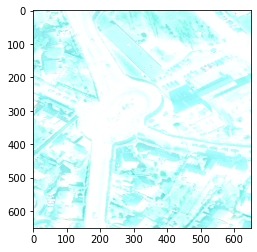

In [135]:
!rm /home/jovyan/work/output/*

os.chdir("/")
img2show = os.listdir("/home/jovyan/data/test/PS-RGB/")[random.randint(0,len(os.listdir("/data/test/PS-RGB/")))]
gtif = gdal.Open('/home/jovyan/data/test/PS-RGB/' + img2show)
image = gtif.ReadAsArray()
plt.imshow(reshape_as_image(image))

!python ~/work/unet/predict.py latest {os.listdir("data/test/PS-RGB/")[random.randint(0,len(os.listdir("/data/test/PS-RGB/")))]}

Ok we just generated a prediction for the image shown above. Lets see what it looks like

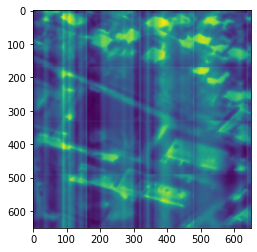

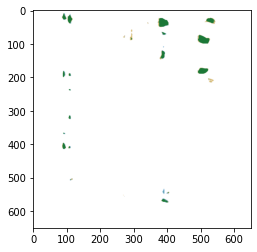

In [136]:
gtif = gdal.Open('/home/jovyan/work/output/result.tif')
image2 = gtif.ReadAsArray()

gtif = gdal.Open('/home/jovyan/work/output/map.tif')
map = gtif.ReadAsArray()

plt.subplots(1,3,figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
plt.imshow(image2)
plt.subplot(1,3,3)
plt.imshow(reshape_as_image(map))
plt.show()

gtif = None

Well, as you can see the prediction is not that great.